Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn import preprocessing # Import label encoder 
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 1.2 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.36
    Uninstalling Cython-0.29.36:
      Successfully uninstalled Cython-0.29.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hdbscan 0.8.33 requires cython<3,>=0.27, but you have cython 3.0.11 which is incompatible.


**Jumping to final merged data -FIRMS and ACLED data**


In [4]:
#acfi_joined = pd.read_csv("af_20_23.csv", encoding = "latin1")
acfi_joined = pd.read_csv("af_20_23_cleaned.csv", encoding = "latin1")

In [5]:
acfi_joined

,grid_id,year,fireCount,acled_count,acled_event_ids,geo_fire,geo_acled
0,"48,28",2000,0,0,[],"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
1,"48,28",2001,2,0,[],"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
2,"48,28",2002,1,0,[],"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
3,"48,28",2003,7,1,"[SUD1707, SUD1707]","{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
4,"48,28",2004,9,0,[],"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
...,...,...,...,...,...,...,...
20395,"85,41",2019,1,0,[],"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
20396,"85,41",2020,1,0,[],"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
20397,"85,41",2021,1,0,[],"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
20398,"85,41",2022,1,0,[],"{""geodesic"":false,""crs"":{""type"":""name"",""proper...","{""geodesic"":false,""crs"":{""type"":""name"",""proper..."


In [6]:
acfi_joined.grid_id.count()

20400

**In our final joined data we 20400 grid_ids**

In [7]:
# Find grid_id with maximum fire count
max_fire_grid = acfi_joined.loc[acfi_joined['fireCount'].idxmax(), 'grid_id']
max_fire_count = acfi_joined['fireCount'].max()

print(f"Grid ID with maximum fire count: {max_fire_grid}")
print(f"Maximum fire count: {max_fire_count}")

Grid ID with maximum fire count: 79,29
Maximum fire count: 44


In [8]:
# Find grid_id with maximum acled count
max_acled_grid = acfi_joined.loc[acfi_joined['acled_count'].idxmax(), 'grid_id']
max_acled_count = acfi_joined['acled_count'].max()

print(f"Grid ID with maximum acled count: {max_acled_grid}")
print(f"Maximum acled count: {max_acled_count}")

Grid ID with maximum acled count: 72,34
Maximum acled count: 2350


**CHECKING FOR NULL VALUES**

In [9]:
#counting NULL values by Column
acfi_joined.isnull().sum(axis=0).sort_values(ascending=False)[:12]

grid_id            0
year               0
fireCount          0
acled_count        0
acled_event_ids    0
geo_fire           0
geo_acled          0
dtype: int64

In [10]:
#Counting Null values by Rows
acfi_joined.isnull().sum(axis=1).sort_values(ascending=False).head(20)

0        0
13597    0
13604    0
13603    0
13602    0
13601    0
13600    0
13599    0
13598    0
13596    0
13606    0
13595    0
13594    0
13593    0
13592    0
13591    0
13590    0
13589    0
13605    0
13607    0
dtype: int64

**Process of making a geo-dataframe**

In [11]:
import json
# Converting the JSON strings to dictionaries for proper comparison
acfi_joined['geo_acled'] = acfi_joined['geo_acled'].apply(json.loads)
acfi_joined['geo_fire'] = acfi_joined['geo_fire'].apply(json.loads)

# Checking if the geo_acled and geo_fire columns are the same
acfi_joined['geo_equal'] = acfi_joined['geo_acled'] == acfi_joined['geo_fire']

In [12]:
acfi_joined

,grid_id,year,fireCount,acled_count,acled_event_ids,geo_fire,geo_acled,geo_equal
0,"48,28",2000,0,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True
1,"48,28",2001,2,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True
2,"48,28",2002,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True
3,"48,28",2003,7,1,"[SUD1707, SUD1707]","{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True
4,"48,28",2004,9,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True
...,...,...,...,...,...,...,...,...
20395,"85,41",2019,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True
20396,"85,41",2020,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True
20397,"85,41",2021,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True
20398,"85,41",2022,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True


In [13]:
from shapely.geometry import shape

# If all geo_equal are True, use geo_acled for creating GeoDataFrame
if acfi_joined['geo_equal'].all():
    # Convert the 'geo_acled' column to shapely geometries
    acfi_joined['geometry'] = acfi_joined['geo_acled'].apply(lambda x: shape(x))

    # Create a GeoDataFrame
    gdf_acfi = gpd.GeoDataFrame(acfi_joined, geometry='geometry')

    print(gdf_acfi)  # Display the GeoDataFrame
else:
    print("The geo_acled and geo_fire columns are not all the same.")    
    

      grid_id  year  fireCount  acled_count     acled_event_ids  \
0       48,28  2000          0            0                  []   
1       48,28  2001          2            0                  []   
2       48,28  2002          1            0                  []   
3       48,28  2003          7            1  [SUD1707, SUD1707]   
4       48,28  2004          9            0                  []   
...       ...   ...        ...          ...                 ...   
20395   85,41  2019          1            0                  []   
20396   85,41  2020          1            0                  []   
20397   85,41  2021          1            0                  []   
20398   85,41  2022          1            0                  []   
20399   85,41  2023          1            0                  []   

                                                geo_fire  \
0      {'geodesic': False, 'crs': {'type': 'name', 'p...   
1      {'geodesic': False, 'crs': {'type': 'name', 'p...   
2      {'geodes

In [14]:
gdf_acfi

,grid_id,year,fireCount,acled_count,acled_event_ids,geo_fire,geo_acled,geo_equal,geometry
0,"48,28",2000,0,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,28",2001,2,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
2,"48,28",2002,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
3,"48,28",2003,7,1,"[SUD1707, SUD1707]","{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
4,"48,28",2004,9,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
...,...,...,...,...,...,...,...,...,...
20395,"85,41",2019,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((38.17840 18.41546, 38.62756 18.41546..."
20396,"85,41",2020,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((38.17840 18.41546, 38.62756 18.41546..."
20397,"85,41",2021,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((38.17840 18.41546, 38.62756 18.41546..."
20398,"85,41",2022,1,0,[],"{'geodesic': False, 'crs': {'type': 'name', 'p...","{'geodesic': False, 'crs': {'type': 'name', 'p...",True,"POLYGON ((38.17840 18.41546, 38.62756 18.41546..."


In [15]:
gdf_acfi = gdf_acfi.drop(columns = ['geo_fire', 'geo_acled', 'geo_equal'])

In [16]:
gdf_acfi

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry
0,"48,28",2000,0,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
1,"48,28",2001,2,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
2,"48,28",2002,1,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
3,"48,28",2003,7,1,"[SUD1707, SUD1707]","POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
4,"48,28",2004,9,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641..."
...,...,...,...,...,...,...
20395,"85,41",2019,1,0,[],"POLYGON ((38.17840 18.41546, 38.62756 18.41546..."
20396,"85,41",2020,1,0,[],"POLYGON ((38.17840 18.41546, 38.62756 18.41546..."
20397,"85,41",2021,1,0,[],"POLYGON ((38.17840 18.41546, 38.62756 18.41546..."
20398,"85,41",2022,1,0,[],"POLYGON ((38.17840 18.41546, 38.62756 18.41546..."


In [17]:
gdf_acfi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   grid_id          20400 non-null  object  
 1   year             20400 non-null  int64   
 2   fireCount        20400 non-null  int64   
 3   acled_count      20400 non-null  int64   
 4   acled_event_ids  20400 non-null  object  
 5   geometry         20400 non-null  geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 956.4+ KB


# Check firecount and Acled spread by year

In [18]:
# gdf_temp = gdf_new[gdf_new['year'] == 2004]

In [19]:
# gdf_temp.plot(x = 'fireCount', y= 'acled_count', kind = 'scatter')

# Panel Regression - from Datascience article
https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

## Adding Log Columns

In [20]:
# Take the log of fireCount and acled_count
gdf_acfi['log_fireCount'] = np.log(gdf_acfi['fireCount']+1)
gdf_acfi['log_acled_count'] = np.log(gdf_acfi['acled_count']+1)

In [21]:
gdf_acfi.head()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count
0,"48,28",2000,0,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",0.0000,0.0000
1,"48,28",2001,2,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",1.0986,0.0000
2,"48,28",2002,1,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",0.6931,0.0000
3,"48,28",2003,7,1,"[SUD1707, SUD1707]","POLYGON ((21.55957 12.57641, 22.00872 12.57641...",2.0794,0.6931
4,"48,28",2004,9,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",2.3026,0.0000


In [22]:
gdf_acfi.shape

(20400, 8)

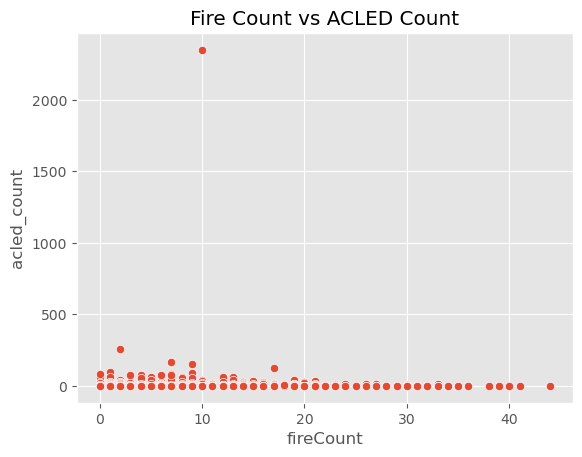

In [23]:
sns.scatterplot(x=gdf_acfi['fireCount'],  
                y=gdf_acfi['acled_count'])
                #hue=df_panel['COUNTRY']).set(title=                 
                #'Y-o-Y % Change in per-capita GDP versus Y-o-Y % Change in Gross capital formation')
# Set the title (optional)
plt.title('Fire Count vs ACLED Count')



# Save the figure
plt.savefig('Fire Count vs ACLED Count.png', dpi=300, bbox_inches='tight')

plt.show()

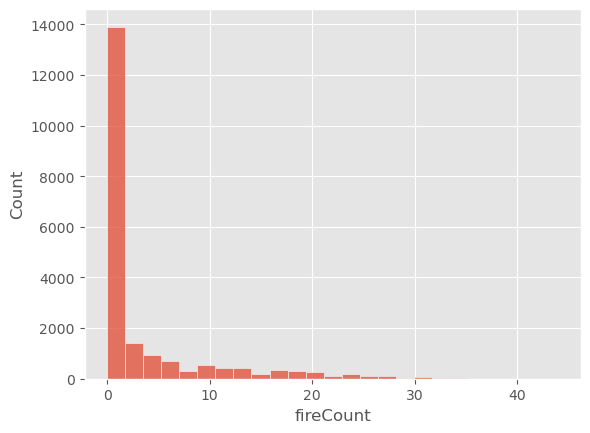

In [24]:
sns.histplot(x=gdf_acfi['fireCount'],bins=25)
plt.show()

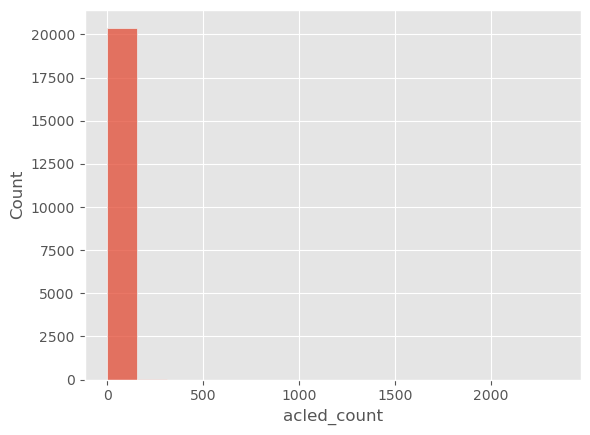

In [25]:
sns.histplot(x=gdf_acfi['acled_count'],bins=15)
plt.show()

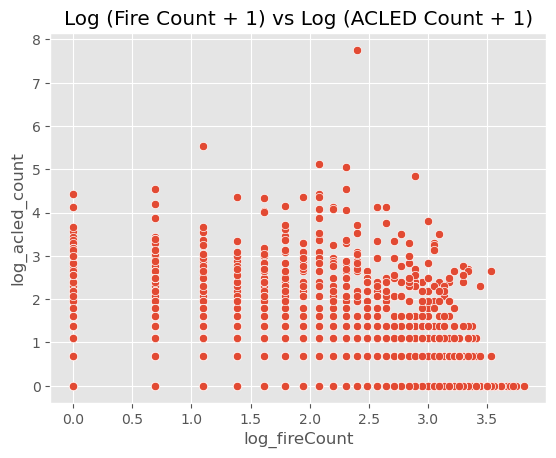

In [26]:
sns.scatterplot(x=gdf_acfi['log_fireCount'],  
                y=gdf_acfi['log_acled_count'])
                #hue=df_panel['COUNTRY']).set(title=                 
                #'Y-o-Y % Change in per-capita GDP versus Y-o-Y % Change in Gross capital formation')
# Set the title (optional)
plt.title('Log (Fire Count + 1) vs Log (ACLED Count + 1)')



# Save the figure
plt.savefig('scatterplot_Log_Value.png', dpi=300, bbox_inches='tight')

plt.show()

The log values of acled count are linearly??? related to firecount across with skewness towards right. There are signs of heteroskedascity in the reponse variable, specifically as variance is not constant for differenct values fire count. This does not bode well for using OLS regression.. 

In [27]:
# Perform PooledOLS
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import compare
import statsmodels.api as sm

from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

import scipy.stats as st
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white

## Step 1: Copy dataset and transform it into the right format.

In [28]:
def data_prep(data,col_list):
    data = data[column_list].copy()
    data = data.set_index(['grid_id', 'year'])
    years = data.index.get_level_values('year').to_list()
    data['year'] = pd.Categorical(years)
    return data

## Step 3: Check goodness of fit

In [29]:
def goodness_of_fit(model_name,residuals,x,y,exog_v):

    print('Mean value of residual errors='+str(residuals.mean()))

    # Plot Q-Q plot of the residual error to check normality 
    sm.qqplot(data=residuals, line='45')
    plt.show()

    # NORMALITY
    
    # Histogram of residuals
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.show()

    # Jarque-Bera Test
    jb_test_stat, jb_p_value = jarque_bera(residuals)
    print(f"Jarque-Bera Test Statistic: {jb_test_stat}")
    print(f"p-value: {jb_p_value}")
    # Interpretation
    if jb_p_value < 0.05:
        print("The null hypothesis of normality is rejected. The data is not normally distributed.")
    else:
        print("The null hypothesis of normality is not rejected. The data is normally distributed.")

    # HETEROSKEDASITY
    
    #  Residual versus X - to check heteroskedasity  
    fig, ax = plt.subplots()
    fig.suptitle('Raw residuals of Pooled OLS versus X')
    plt.ylabel('Residual (y - mu)')
    plt.xlabel('X='+str(exog_v[0]))
    #ax.scatter(x[exog_vars[0]], residuals_pooled_OLS, s=4, c='black', label='Residual Error')
    ax.scatter(x[exog_v[0]], residuals, s=4, label='Residual Error')
    plt.show()

    # White Test
    white_test_results = het_white(residuals, x)
    labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
    white_test_r = dict(zip(labels, white_test_results))
    print(white_test_r)
    # Interpretation
    if white_test_results[1] < 0.05:
        print("The LM test’s p-value is < .001 indicating a rejection of the Null hypothesis of the White test that the residuals are homoskedastic.")
    else:
        print("The null hypothesis is not rejected. The data is normally homoskedastic.")

    #Are the residual errors correlated with the response variable y?
    fig, ax = plt.subplots()
    fig.suptitle('Raw residuals of Pooled OLS versus y')
    plt.ylabel('Residual (y - mu)')
    plt.xlabel('y')
    #ax.scatter(y, residuals_pooled_OLS, s=4, c='black', label='Residual Error')
    ax.scatter(y, residuals, s=4, label='Residual Error')
    plt.show()

    # Pearson's Test of Correation
    p_results = st.pearsonr(x=y, y=residuals)
    labels = ['Pearson\'s r:', 'p-value:']
    pearsons_test_r = dict(zip(labels, p_results))
    print('Results of the Pearson\'s r test of correlation between the residual errors and the response variable y ===>')
    #print(lzip(keys,results))
    print(pearsons_test_r)

    # Store Model Results
    goodnessoffit_performance.loc[len(goodnessoffit_performance.index)] = [model_name,residuals.mean(),jb_test_stat, jb_p_value,
                                                                   white_test_results[0],white_test_results[1],p_results[0],
                                                                  p_results[1]]
    

In [30]:
col_names = ['Regression Model','Mean Residual Errors','Jarque-Bera Test Statistic','Jarque-Bera Test p-value',
             'White Test Statistic','White Test p-value','Pearson\'s Test Statistic','Pearson\'s Test p-value']
goodnessoffit_performance = pd.DataFrame(columns=col_names)

## Model: Pooled OLS with Actual Data

The Pooled OLS regression model is often a good starting point and can act as a reference model. Our dependent (endogenous) and explanatory (exogenous) variables are as follows:

Dependent variable y = count of ACLED events in grids 
Explanatory variablexX  count of FIRMS fires in grids =

The Pooled OLS regression model equations as follows:

log_acled_count = beta_cap_1 * fireCount + beta_cap_0 + epsilon


The objective of training the model on the panel data set is to find the fitted coefficients β_cap_1 and β_cap_0. The ‘cap’ in β_cap signifies that it is the value of the coefficient that the model has estimated and it not the true (population level) value β which is always unknown.

ε is the residual error of the fitted model and it is a random variable with a certain mean and variance. If the OLS estimation technique does its job correctly, ε will have a mean value of zero and ε will have a constant variance conditioned upon GCF_GWTH_PCNT (i.e. ε will not be heteroskedastic), and ε will not be auto-correlated. 
** 

In [31]:
column_list = ['grid_id', 'year', 'log_fireCount', 'log_acled_count']

In [32]:
gdf_regression = data_prep(gdf_acfi,column_list)

In [33]:
#exog

exog_vars = ['log_fireCount','year']
#x = sm.add_constant(gdf_regression[exog_vars])
x = sm.tools.tools.add_constant(gdf_regression[exog_vars[0]]) 

#endog

y = gdf_regression['log_acled_count']                               

In [34]:
# MODEL RUN

model_POOLED = PooledOLS(y,x)
results_POOLED = model_POOLED.fit(cov_type='clustered', cluster_entity=True)
#results_POOLED = model_POOLED.fit(cov_type='robust')
#results_POOLED = model_POOLED.fit(cov_type='clustered', cluster_time=True)

# Store values for checking homoskedasticity graphically
fittedvals_POOLED = results_POOLED.predict().fitted_values
residuals_POOLED = results_POOLED.resids

In [35]:
print(results_POOLED)

                          PooledOLS Estimation Summary                          
Dep. Variable:        log_acled_count   R-squared:                        0.0402
Estimator:                  PooledOLS   R-squared (Between):              0.0790
No. Observations:               20400   R-squared (Within):               0.0041
Date:                Wed, Aug 14 2024   R-squared (Overall):              0.0402
Time:                        21:51:30   Log-likelihood                 -1.26e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      855.14
Entities:                         850   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                 F(1,20398)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             78.321
                            

**Analysis of goodness-of-fit via R-squared, F-test, Log-Likelihood and AIC**

The R-squared which measures the fraction of the total variance in y that is explained byxs is 007179 or about72 is very low..

The F-test for regression that measures the joint significance of the model’s parameters has produced a test statistic 652611.4 with a p-value 0-35 thereby leading us to conclude that the model’s coefficient estimates are jointly significant at a p < .001ures.

**Log-likelihood**

The Log-likelihood of the model is -1.743e+04. These goodness-of-fit values by themselves are meaningless unless we compare them to that of a competing model. In my next week’s article, we' ll a Fixed Effects model on the same data panel and use compare the quality of fit of the FE model with the Pooled OLSR model using these two measures.

Mean value of residual errors=-1.6718652606120003e-17


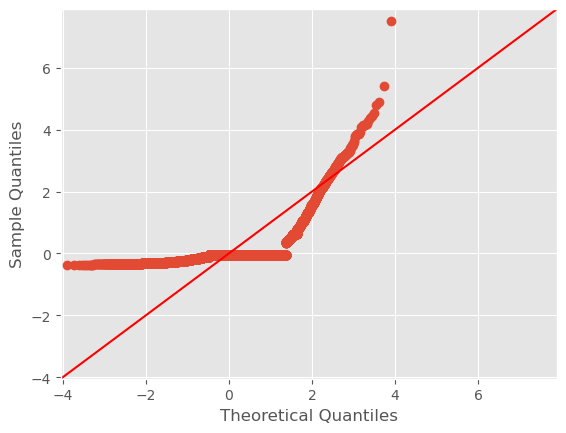

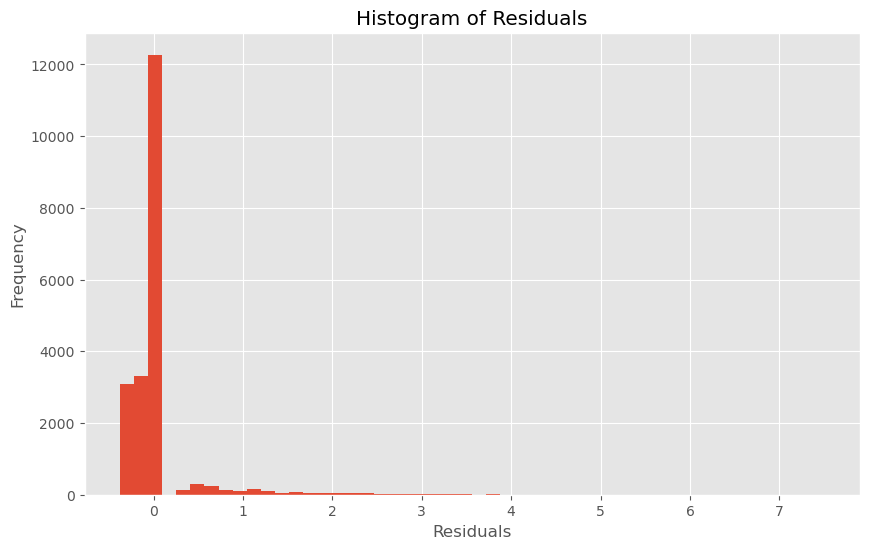

Jarque-Bera Test Statistic: 849663.9230129177
p-value: 0.0
The null hypothesis of normality is rejected. The data is not normally distributed.


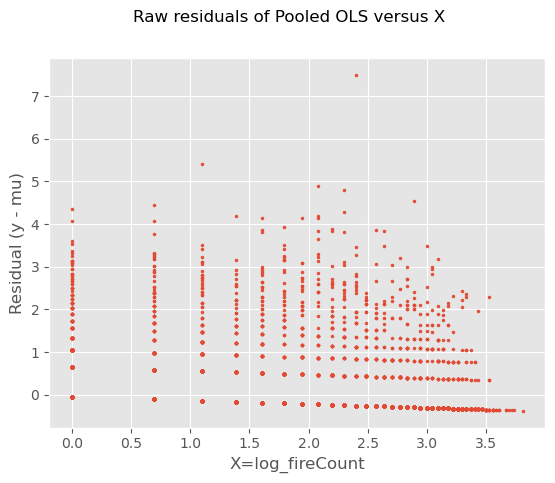

{'LM-Stat': 563.0351435716814, 'LM p-val': 5.476108124691603e-123, 'F-Stat': 289.4653468045549, 'F p-val': 1.0909595650790031e-124}
The LM test’s p-value is < .001 indicating a rejection of the Null hypothesis of the White test that the residuals are homoskedastic.


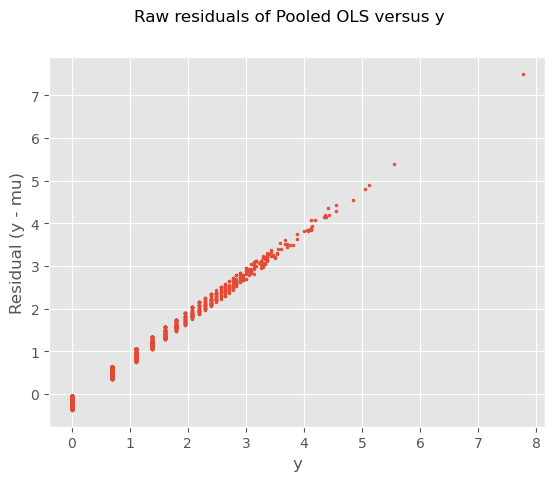

Results of the Pearson's r test of correlation between the residual errors and the response variable y ===>
{"Pearson's r:": 0.9796755741184571, 'p-value:': 0.0}


In [36]:
# Check Goodness of fit
goodness_of_fit('POOLED',residuals_POOLED,x,y,exog_vars)

In [37]:
goodnessoffit_performance

,Regression Model,Mean Residual Errors,Jarque-Bera Test Statistic,Jarque-Bera Test p-value,White Test Statistic,White Test p-value,Pearson's Test Statistic,Pearson's Test p-value
0,POOLED,-0.0000,"849,663.9230",0.0000,563.0351,0.0000,0.9797,0.0000


**Analysis of residual errors**

Let’s analyze the residual errors of the fitted model for **normality, heteroskedasticity and correlation** — the three properties that impact the goodness-of-fit of the linear model.

The mean is practically zero which is the expected outcome of using the OLS estimation technique.

**normality**

Here is where we observe the first sign of a problem. The Q-Q plot of the residuals is a visual test of normality and it clearly shows that the residuals of the fitted model are not normally distributed. If the data is not normally distributed, the points will deviate from the reference line.

Even though the residual errors are not normally distributed, the Pooled OLS estimator is still the Best Linear Unbiased Estimator (BLUE) for the panel data regression problem. Non-normality of residual errors does not affect the BLUE-ness of OLS regression model.

One disadvantage of having residual errors that are not normally distributed is that one cannot build reliable confidence intervals for the model’s predictions. We can tolerate small departures from normality but large departures invalidate the use of either the Normal or the Student’s t-distributions. Consequently, reliable confidence intervals cannot (and therefore should not) be calculate

**heteroskedasticity**

The OLS estimator is not efficient (although it’s still unbiased) if the residual errors of the OLSR model are heteroskedastic, i.e. the variance of residual errors is not constant across all values of X.

When the residuals are heteroskedastic, the OLS estimator becomes inefficient i.e. it loses the ability to generate predictions having the lowest possible variance amongst all possible linear unbiased estimators. When the residuals are heteroskedastic, the OLS estimator will under or over-estimate the variance in the parameter estimates, causing the standard errors of the parameter estimates to be miss-specified. Since standard errors are used for calculating confidence intervals, the confidence intervals of the parameter estimates also become incorrect. The same kind of miss-specification is seen for the standard errors and confidence intervals associated with the model’s predictions.

**correlation**

There seems to be what looks like a linear trend between the residual errors and y. A correlation test using Pearson’s r confirms this visual judgement:
The first value of 0.61499 is the amount of correlation (~ 61%) seen between the residuals and y, and the second value of 3.99645e-18 is the p-value of the result. We will ignore the reported p-value as we know that the residuals are far from being normally distributed. At any rate, the reported correlation (61%) by itself is obviously much greater than zero and therefore, significant.

The high degree of correlation between the residual errors of regression and the response variable indicate that our Pooled OLSR model is missing importan**t explanatory variabl**es which would have otherwise been able to “explain” some of this correlation. Whatever variance in the (y) y thae (Xhas s not been able to explain has leaked into the residuals in the form of both a correlation with y, and heteroskedasticit

Ref: https://medium.com/towards-data-science/how-to-build-a-pooled-ols-regression-model-for-panel-data-sets-a78358f9c2a


---------------------------------------------

Simple OLS requires that there is no correlation between unobserved, independent variable(s) and the IVs (i.e. exogeneity). Let´s write this down: 

Ref: https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8y
y = m1x1 + m2x2 +c
x1, x2 - observered IV - ideaally x1 and x2 should be uncorrelated 

y = m1x1 + n1z1 + c

x1 - observed IV
z1 - un observed IV

-----------------------------------------
.c2a




## Fixed Effect Model

Ref: https://towardsdatascience.com/understanding-the-fixed-effects-regression-model-d2fccc2cc27e

The Fixed Effects regression model is used to estimate the effect of intrinsic characteristics of individuals in a panel data set. Examples of such intrinsic characteristics are genetics, acumen and cultural factors. Such factors are not directly observable or measurable but one needs to find a way to estimate their effects since leaving them out leads to a sub-optimally trained regression model. The Fixed Effects model is designed to address this problem.

we can express the general form of the linear regression model

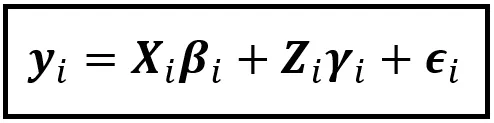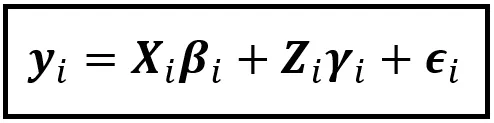

In the above equation:

y_i is a matrix of size [T x 1] containing the T observations for country i.
X_i is a matrix of size [T x k] containing the values of k regression variables all of which are observable and relevant.
β_i is a matrix of size [k x 1] containing the population (true)values of regression coefficients for the k regression variables.
Z_i is a matrix of size [T x m] containing the (theoretical) values of all the variables (m in number) and effects that cannot be directly observed.
γ_i is a matrix of size [m x 1] containing the (theoretical) population values of regression coefficients for the m unobservable variables.
ε_i is a matrix of size [T x 1] containing the errors corresponding to the T observations for cou

All unit-specific effects are assumed to be introduced by the term Z_iγ_i. The matrix Z_i and its coefficients vector γ_i are purely theoretical terms since what they represent cannot be in reality observed and measured.
Since z_i is not directly observable, in order to measure the effects of z_i, we need to formalize the effect of leaving out z_i. Fortunately, there is a well-studied concept in statistics called the omitted-variable bias which we can use for this purpose.

Omitted variable bias
While training the model on the panel data set, if we leave out z_i from the model, it will cause what is known as the omitted variable bias. It can be shown that if the regression model is estimated without considering z_i, then the estimated values β_cap_i of the coefficients β_i will be biased as follo

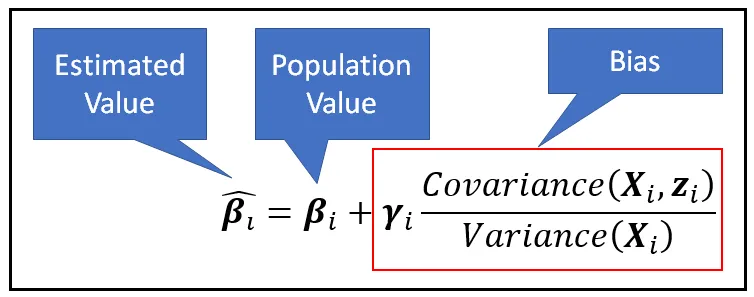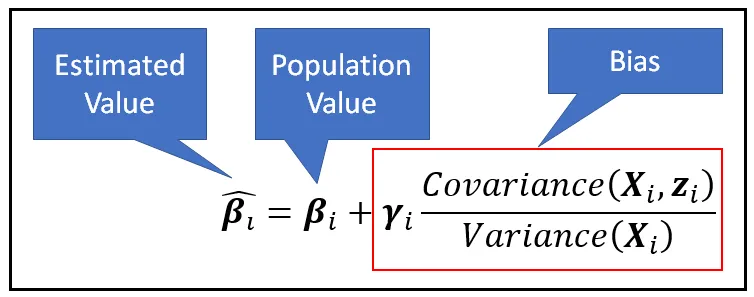

The above equation suggests an approach for constructing the following two kinds of models — the Fixed Effects model, and the Random Effects model depending on whether or not the Covariance term in the above equation is zero, i.e. whether or not the unobservable effects z_i are correlated with the regression variables.
The Fixed Effects Regression Model

In this model, we assume that the unobservable individual effects z_i are correlated with the regression variables. In effect, it means that the Covariance(X_i, z_i) in the above equation is non-zero

we also assume that the bias introduced due to the omission of the unit-specific factors is group-specific.

To compensate for this bias, we will introduce a group-specific intercept called c_i into the model. c_i is assumed to act in a direction that is opposite (in a vector sense) to the effect of the omitted-variable bias.

With these two assumptions in place, we will express the Fixed Effects regression model’s equation as foll

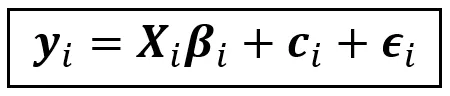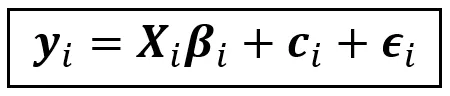ows:.

ws:
ntry i.

In [38]:
column_list = ['grid_id','year','log_fireCount', 'log_acled_count']

In [39]:
gdf_regression = data_prep(gdf_acfi,column_list)

In [40]:
#exog

exog_vars = ['log_fireCount','year']
#x = sm.add_constant(gdf_regression[exog_vars])
x = sm.tools.tools.add_constant(gdf_regression[exog_vars[0]]) 

#endog

y = gdf_regression['log_acled_count']                               

In [41]:
# Run the fixed effects model
#model_FE = PanelOLS(y, x) - same as PooledOLS

model_FE_ET = PanelOLS(y, x, entity_effects=True, time_effects=True)
results_FE_ET = model_FE_ET.fit(use_lsdv = True)

model_FE_E = PanelOLS(y, x, entity_effects=True, time_effects=False)
results_FE_E = model_FE_E.fit(use_lsdv = True)

model_FE_T = PanelOLS(y, x, entity_effects=False, time_effects=True)
results_FE_T = model_FE_T.fit(use_lsdv = True)

In [42]:
#Compare Results
print(compare({'Fixed Effect_ET': results_FE_ET, 'Fixed Effect_E': results_FE_E, 'Fixed Effect_T': results_FE_T}))

                                  Model Comparison                                 
                            Fixed Effect_ET      Fixed Effect_E      Fixed Effect_T
-----------------------------------------------------------------------------------
Dep. Variable               log_acled_count     log_acled_count     log_acled_count
Estimator                          PanelOLS            PanelOLS            PanelOLS
No. Observations                      20400               20400               20400
Cov. Est.                        Unadjusted          Unadjusted          Unadjusted
R-squared                            0.0027              0.0054              0.0389
R-Squared (Within)                   0.0050              0.0054              0.0043
R-Squared (Between)                  0.0547              0.0685              0.0787
R-Squared (Overall)                  0.0290              0.0359              0.0402
F-statistic                          52.493              106.90             

The results you provided summarize the output of three different fixed-effect regressions on panel data. Each regression model explains the logged count of ACLED events (`log_acled_count`) using the logged count of fire incidents (`log_fireCount`) as the independent variable. Here’s a breakdown of the results:

### 1. **Model Comparison Overview**
   - **Dep. Variable**: The dependent variable for all models is `log_acled_count`.
   - **Estimator**: All models use the PanelOLS (Panel Ordinary Least Squares) estimator with fixed effects.
   - **No. Observations**: Each model includes 20,400 observations.
   - **Cov. Est.**: The covariance matrix is unadjusted in all models.

### 2. **Different Models**
   - **Fixed Effect_ET (Entity-Time Fixed Effects)**
     - **Fixed Effect_E (Entity Fixed Effects)**
     - **Fixed Effect_T (Time Fixed Effects)**

### 3. **Key Metrics**
   - **R-squared**: Measures the proportion of variance in the dependent variable explained by the independent variables.
     - **R-squared** values are relatively low across all models, indicating that `log_fireCount` does not explain much of the variation in `log_acled_count`.
   - **R-Squared (Within)**: Represents the variation explained within entities or time periods.
     - Similar low values for all models, suggesting little within-variation is captured.
   - **R-Squared (Between)**: Measures the variation between entities or time periods.
     - Higher in the **Fixed Effect_T** model, indicating better performance in explaining differences across time.
   - **R-Squared (Overall)**: A combination of within and between R-squared.
     - Slightly higher in the **Fixed Effect_T** model, which suggests this model explains a bit more of the overall variation in the data.
   - **F-statistic**: Tests the joint significance of all coefficients.
     - All models show highly significant F-statistics (p-value = 0.0000), meaning that at least some of the coefficients are significantly different from zero.

### 4. **Coefficient Estimates**
   - **const (Intercept)**: The constant term varies slightly across models.
     - Positive and statistically significant, indicating a positive baseline value for `log_acled_count` when `log_fireCount` is zero.
   - **log_fireCount**: The main variable of interest.
     - The coefficient is positive across all models, meaning that an increase in fire incidents is associated with an increase in ACLED events.
     - The magnitude of the effect is smallest in the **Fixed Effect_ET** model (0.0530) and largest in the **Fixed Effect_T** model (0.1117).
     - All coefficients are statistically significant, as indicated by the high t-statistics (values in parentheses).

### 5. **Interpretation of Fixed Effects**
   - **Fixed Effect_ET**: This model controls for both entity (e.g., country, region) and time (e.g., year, month) fixed effects.
     - Captures any unobserved factors that vary across both entities and time.
   - **Fixed Effect_E**: This model controls for entity fixed effects only.
     - Accounts for unobserved characteristics that vary across entities but are constant over time.
   - **Fixed Effect_T**: This model controls for time fixed effects only.
     - Accounts for factors that vary across time but are constant across entities.

### **Summary**
- The **Fixed Effect_T** model appears to explain slightly more variation overall than the other models, particularly in capturing time-specific variations.
- The association between `log_fireCount` and `log_acled_count` is positive and significant across all models, but the strength of this association varies depending on the type of fixed effects used.
- The **Fixed Effect_ET** model has the smallest coefficient for `log_fireCount`, suggesting that when controlling for both entity and time, the impact of fire incidents on ACLED events is smaller.

**Clustering on entity reduced the t-stats across the board. This suggests there is important correlation in the residuals per entity. Clustering by both also decreases the t-stats which suggests that there is cross-sectional dependence in the data. Note: clustering by entity addresses correlation across time and clustering by time controls for correlation between entities in a time period.**

**In the provided regression results, the t-statistic for log_fireCount is 30.117 in the Fixed Effect_T model. This very high value indicates that the effect of log_fireCount on log_acled_count is highly significant and unlikely to be due to random chance.**

**In the Fixed Effect_ET model, the t-statistic for log_fireCount is 7.4377, which, while still significant, is much lower than in the other models. This suggests that the confidence in the effect of log_fireCount on log_acled_count is somewhat weaker in this model compared to the others.**

Ref: https://bashtage.github.io/linearmodels/panel/examples/examples.html
---------------------
General Thresholds for t-Statistics
t-statistic > 2 or < -2: Typically indicates statistical significance at the 5% level, implying strong evidence against the null hypothesis.
t-statistic close to 0: Suggests that the coefficient is not significantly different from zero, indicating little to no effect.
t-statistic between 1.5 and 2: May be considered marginally significant, depending on the context and field of study.
---------------------



In [43]:

# Store values for checking homoskedasticity graphically
fittedvals_FE = results_FE_ET.predict().fitted_values
residuals_FE = results_FE_ET.resids

In [44]:
# Print the summary of the results - entity effect
print(results_FE_T)

                          PanelOLS Estimation Summary                           
Dep. Variable:        log_acled_count   R-squared:                        0.0389
Estimator:                   PanelOLS   R-squared (Between):              0.0787
No. Observations:               20400   R-squared (Within):               0.0043
Date:                Wed, Aug 14 2024   R-squared (Overall):              0.0402
Time:                        21:52:34   Log-likelihood                -1.231e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      825.24
Entities:                         850   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                 F(1,20375)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             825.24
                            

Mean value of residual errors=-8.997160315246612e-17


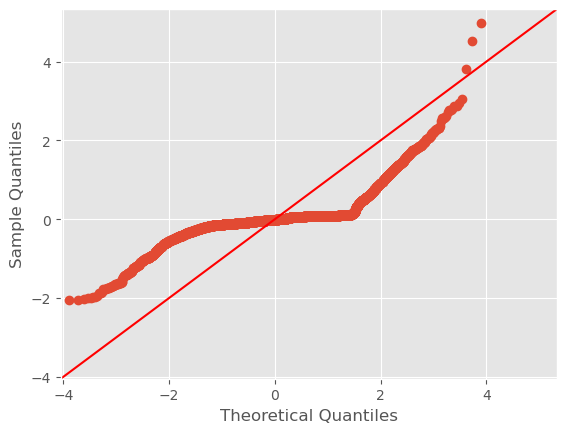

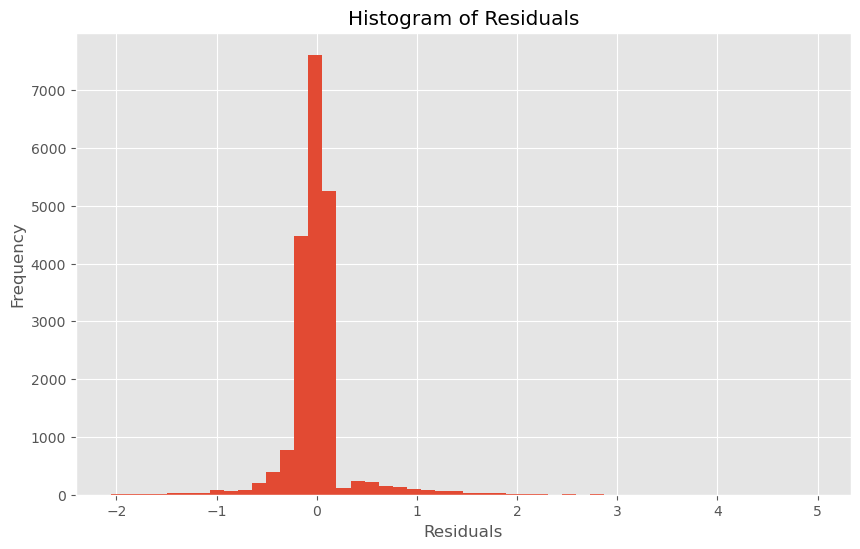

Jarque-Bera Test Statistic: 398755.8838520133
p-value: 0.0
The null hypothesis of normality is rejected. The data is not normally distributed.


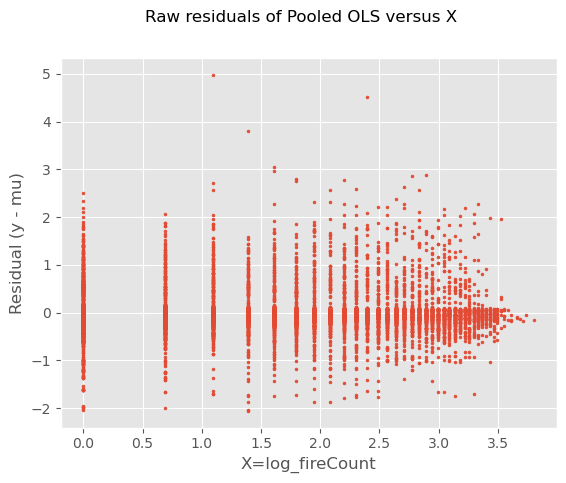

{'LM-Stat': 659.8630248763965, 'LM p-val': 5.158990665735955e-144, 'F-Stat': 340.910150100911, 'F p-val': 2.3193345800706934e-146}
The LM test’s p-value is < .001 indicating a rejection of the Null hypothesis of the White test that the residuals are homoskedastic.


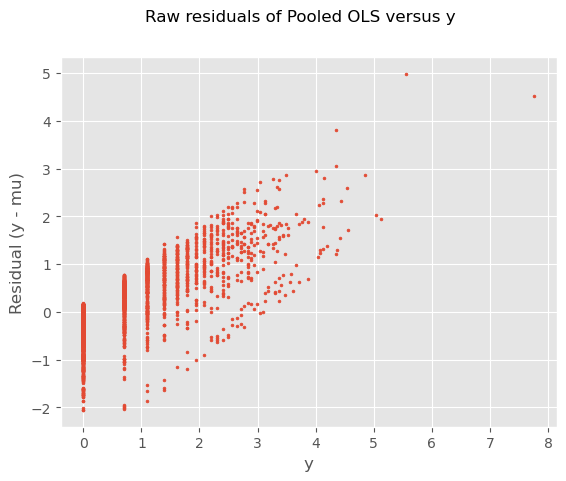

Results of the Pearson's r test of correlation between the residual errors and the response variable y ===>
{"Pearson's r:": 0.6978088307416208, 'p-value:': 0.0}


In [45]:
goodness_of_fit('Fixed Effect',residuals_FE,x,y,exog_vars)

In [46]:
goodnessoffit_performance

,Regression Model,Mean Residual Errors,Jarque-Bera Test Statistic,Jarque-Bera Test p-value,White Test Statistic,White Test p-value,Pearson's Test Statistic,Pearson's Test p-value
0,POOLED,-0.0000,"849,663.9230",0.0000,563.0351,0.0000,0.9797,0.0000
1,Fixed Effect,-0.0000,"398,755.8839",0.0000,659.8630,0.0000,0.6978,0.0000


## Random Effect Model

In [47]:
# Random Effects odel
model_RE = RandomEffects(y,x) 
results_RE = model_RE.fit() 

# Store values for checking homoskedasticity graphically
fittedvals_RE = results_RE.predict().fitted_values
residuals_RE = results_RE.resids

In [48]:
# Print the summary of the results - entity effect
print(results_RE)

                        RandomEffects Estimation Summary                        
Dep. Variable:        log_acled_count   R-squared:                        0.0084
Estimator:              RandomEffects   R-squared (Between):              0.0726
No. Observations:               20400   R-squared (Within):               0.0054
Date:                Wed, Aug 14 2024   R-squared (Overall):              0.0378
Time:                        21:53:49   Log-likelihood                   -6683.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      172.05
Entities:                         850   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                 F(1,20398)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             172.05
                            

Mean value of residual errors=3.483052626275001e-19


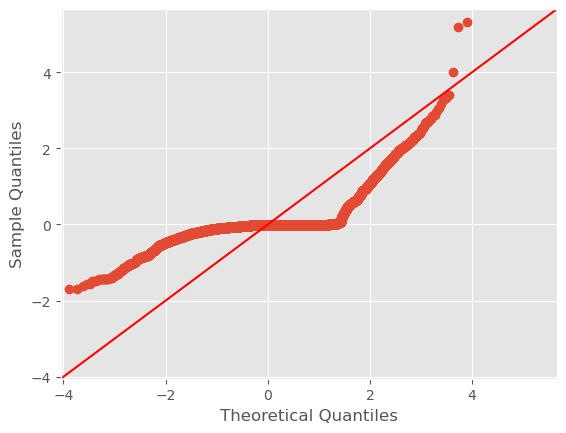

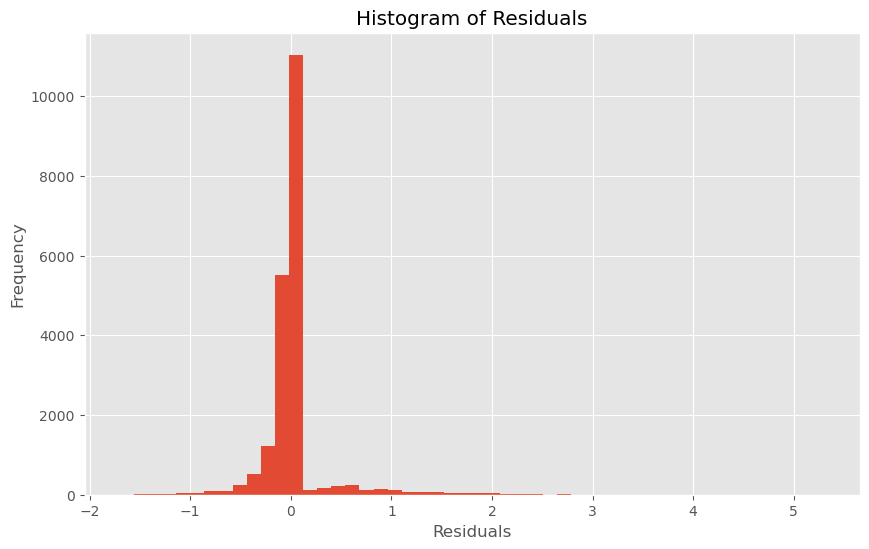

Jarque-Bera Test Statistic: 593617.9427310257
p-value: 0.0
The null hypothesis of normality is rejected. The data is not normally distributed.


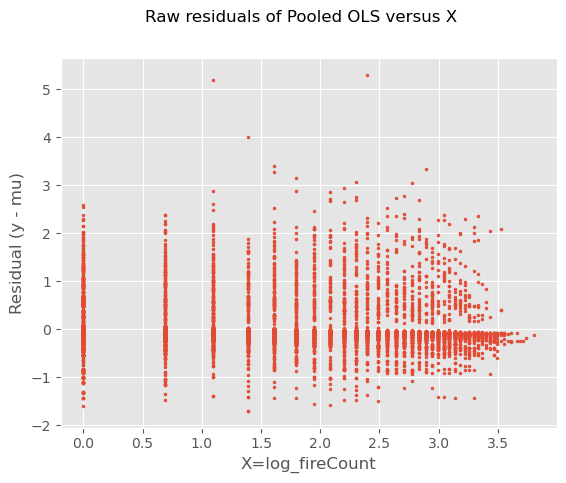

{'LM-Stat': 661.6440076479009, 'LM p-val': 2.117528416295402e-144, 'F-Stat': 341.86111622526414, 'F p-val': 9.241470079202116e-147}
The LM test’s p-value is < .001 indicating a rejection of the Null hypothesis of the White test that the residuals are homoskedastic.


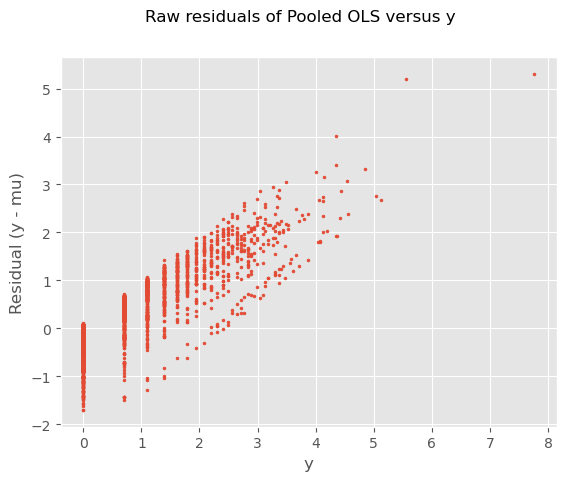

Results of the Pearson's r test of correlation between the residual errors and the response variable y ===>
{"Pearson's r:": 0.8410783665723726, 'p-value:': 0.0}


In [49]:
goodness_of_fit('Random Effects',residuals_RE,x,y,exog_vars)

In [50]:
goodnessoffit_performance

,Regression Model,Mean Residual Errors,Jarque-Bera Test Statistic,Jarque-Bera Test p-value,White Test Statistic,White Test p-value,Pearson's Test Statistic,Pearson's Test p-value
0,POOLED,-0.0000,"849,663.9230",0.0000,563.0351,0.0000,0.9797,0.0000
1,Fixed Effect,-0.0000,"398,755.8839",0.0000,659.8630,0.0000,0.6978,0.0000
2,Random Effects,0.0000,"593,617.9427",0.0000,661.6440,0.0000,0.8411,0.0000


In [51]:
from linearmodels.panel import compare

print(compare({'POOLED': results_POOLED, 'Fixed Effect': results_FE_ET, 'Random Effects': results_RE}))

                                  Model Comparison                                 
                                     POOLED        Fixed Effect      Random Effects
-----------------------------------------------------------------------------------
Dep. Variable               log_acled_count     log_acled_count     log_acled_count
Estimator                         PooledOLS            PanelOLS       RandomEffects
No. Observations                      20400               20400               20400
Cov. Est.                         Clustered          Unadjusted          Unadjusted
R-squared                            0.0402              0.0027              0.0084
R-Squared (Within)                   0.0041              0.0050              0.0054
R-Squared (Between)                  0.0790              0.0547              0.0726
R-Squared (Overall)                  0.0402              0.0290              0.0378
F-statistic                          855.14              52.493             

The results you provided compare three different regression models for analyzing the relationship between the logged count of ACLED events (`log_acled_count`) and the logged count of fire incidents (`log_fireCount`). The models are **Pooled OLS**, **Fixed Effects (Entity and Time)**, and **Random Effects**. Here’s an interpretation of the results:

### 1. **Model Overview**

- **Pooled OLS**: This model assumes that there are no individual-specific effects or time-specific effects. It treats the data as if it were a single large cross-sectional dataset, ignoring any panel structure.
  
- **Fixed Effects (Entity and Time)**: This model controls for unobserved heterogeneity by allowing for individual-specific (entity) and time-specific fixed effects. It captures the effects that vary across entities and over time but are constant within an entity or time period.

- **Random Effects**: This model assumes that the individual-specific effects are random and uncorrelated with the independent variables. It allows for variation across entities but assumes that these variations are randomly distributed.

### 2. **Key Metrics Interpretation**

- **No. Observations**: All models use the same dataset with 20,400 observations.

- **Cov. Est. (Covariance Estimator)**:
  - **Pooled OLS**: Uses a clustered covariance estimator, likely clustered at the entity level, to account for potential within-entity correlation.
  - **Fixed Effects and Random Effects**: Use unadjusted covariance estimators.

- **R-squared**: 
  - **Pooled OLS (0.0440)**: Indicates that approximately 4.4% of the variation in `log_acled_count` is explained by `log_fireCount`.
  - **Fixed Effects (0.0028)**: Much lower R-squared, indicating that the model explains very little of the variation in the dependent variable when entity and time effects are controlled for.
  - **Random Effects (0.0090)**: Better than Fixed Effects but still explains only a small portion of the variation.

- **R-Squared (Within, Between, Overall)**:
  - **Within**: Measures variation explained within entities over time.
    - Highest for the **Random Effects** model (0.0057), suggesting it slightly better captures within-entity variation compared to the others.
  - **Between**: Measures variation explained between entities.
    - **Pooled OLS (0.0869)**: Performs best here, indicating it captures between-entity differences well.
  - **Overall**: Combination of within and between R-squared.
    - **Pooled OLS (0.0440)**: Again, performs best overall.

- **F-statistic and P-value**:
  - All models have a significant F-statistic (p-value = 0.0000), indicating that the model as a whole is statistically significant.
  - **Pooled OLS (F = 938.60)**: Strongest model fit according to the F-statistic.
  - **Fixed Effects (F = 55.319)**: Significantly lower, indicating that this model has a weaker overall fit when controlling for entity and time effects.
  - **Random Effects (F = 185.29)**: Moderate fit compared to the others.

### 3. **Coefficient Estimates and t-Statistics**

- **const (Intercept)**:
  - **Pooled OLS (0.0736, t = 7.1226)**: Significant and positive, indicating a baseline level of ACLED events when `log_fireCount` is zero.
  - **Fixed Effects (0.1193, t = 19.745)**: Higher intercept, significant as well, suggesting the model estimates a higher baseline with fixed effects.
  - **Random Effects (0.0950, t = 6.6849)**: Intercept is between the other two models, also significant.

- **log_fireCount**:
  - **Pooled OLS (0.1148, t = 9.2856)**: Suggests a 10% increase in fire incidents is associated with an approximately 1.15% increase in ACLED events. The t-statistic is high, indicating strong statistical significance.
  - **Fixed Effects (0.0530, t = 7.4377)**: The effect size is smaller, with a 10% increase in fire incidents associated with only a 0.53% increase in ACLED events. The t-statistic is still significant but lower than in Pooled OLS.
  - **Random Effects (0.0858, t = 13.612)**: The effect size is in between the other two models, with a 10% increase in fire incidents leading to an 0.86% increase in ACLED events. The t-statistic is higher than in the other models, indicating strong significance.

### **Summary and Model Comparison**

- **Pooled OLS**: This model shows the highest R-squared and F-statistic, suggesting it explains more variation overall. However, it does not account for entity-specific or time-specific effects, which can lead to biased estimates if such effects are present.

- **Fixed Effects**: This model accounts for unobserved heterogeneity across entities and time but results in a much lower R-squared and a smaller coefficient for `log_fireCount`. This suggests that when controlling for these effects, the relationship between fire incidents and ACLED events is weaker.

- **Random Effects**: This model strikes a balance between the other two, showing moderate R-squared values and a significant effect of `log_fireCount`. It assumes the entity effects are random and not correlated with the independent variables, which may or may not be a valid assumption depending on the data.

In choosing between these models:
- **If you believe there are unobserved factors specific to entities or time periods that might bias the results**, the **Fixed Effects** model is preferable despite its lower explanatory power.
- **If the random effects assumption is valid (uncorrelated with independent variables)**, the **Random Effects** model might offer a good compromise between bias and efficiency.
- **If the panel structure is not important or if there's confidence that there's no significant unobserved heterogeneity**, the **Pooled OLS** model offers a simple and strong overall fit.

Choosing between PooledOLS and FE/RE: Basically, there are five assumptions for simple linear regression models that must be fulfilled. Two of them can help us in choosing between PooledOLS and FE/RE.

These assumptions are (1) Linearity, (2) Exogeneity, (3a) Homoskedasticity and (3b) Non-autocorrelation, (4) Independent variables are not Stochastic and (5) No Multicolinearity.

If assumption (2) or (3) (or both) are violated, then FE or RE might be more suitable.

I would recommend to start performing PooledOLS. Since it can be seen as a simple OLS model, it has to fulfill certain assumptions (those in the chapter “How to decide which Model is appropriate?” ). As stated above, if condition 2 or 3 (or both) are violated, then FE-/RE-models are likely more suitable. Since condition 2 can only be tested further down with the Hausman-Test, we will stick to proving condition 3 for now.



Check condition 3:

Condition 3 is splitted in 3a (Homoskedasticity) and 3b (Non-Autocorrelation). Those assumptions can be tested with a number of different tests. For condition 3a, I will show you how to identify heteroscedasticity graphically as well as perform the White-Test and Breusch-Pagan-Test (both are similar). For condition 3b, I will show you the Durbin-Watson-Test.

In [52]:
# # 3A. Homoskedasticity
# import matplotlib.pyplot as plt
# # 3A.1 Residuals-Plot for growing Variance Detection
# fig, ax = plt.subplots()
# ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
# ax.axhline(0, color = 'r', ls = '--')
# ax.set_xlabel('Predicted Values', fontsize = 15)
# ax.set_ylabel('Residuals', fontsize = 15)
# ax.set_title('Homoskedasticity Test', fontsize = 30)
# plt.show()

Basically, a residuals-plot represents predicted values (x-axis) vs. residuals (y-axis). If the plotted data points spread out, this is an indicator for growing variance and thus, for heteroskedasticity. Since this seems to be the case in our example, we might have the first violation. But let´s check this with the White- and the Breusch-Pagan-Test:



In [53]:
# # 3A.2 White-Test
# from statsmodels.stats.diagnostic import het_white, het_breuschpagan
# pooled_OLS_dataset = pd.concat([gdf_regression, residuals_pooled_OLS], axis=1)
# pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
# x = sm.tools.tools.add_constant(gdf_regression['fireCount']).fillna(0)
# white_test_results = het_white(pooled_OLS_dataset['residual'], x)
# labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
# print(dict(zip(labels, white_test_results)))

# # 3A.3 Breusch-Pagan-Test
# breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], x)
# labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
# print(dict(zip(labels, breusch_pagan_test_results)))

In simple terms, if p < 0.05, then heteroskedasticity is indicated. Both tests give very small p-values (White-test: 3.442621728589391e-44, Breusch-Pagan-test: 6.032616972194746e-2


** In our case p > 0.05, h heteroskedasticity is not indicated  **



In [55]:
# # 3.B Non-Autocorrelation
# # Durbin-Watson-Test
# from statsmodels.stats.stattools import durbin_watson

# durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
# print(durbin_watson_test_results)

The Durbin-Watson-Test will have one output between 0 – 4. The mean (= 2) would indicate that there is no autocorrelation identified, 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation), and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation).

In our case the result is 1.7086665034473183, which clearly indicates weak positive autocorrelation or no autocorrelation. This may be due to presence of anonymous fires in the data. If we can remove anonymous fires - it may help us improving the coorelation.

# Checking Anomalous Fires

In [56]:
gdf_acfi.sample()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count
8890,"64,42",2010,0,0,[],"POLYGON ((28.74609 18.86462, 29.19525 18.86462...",0.0000,0.0000


In [57]:
# gridlist = gdf_acfi.grid_id.unique()
# print(len(gridlist))

In [58]:
# # Initialize the dictionary to store results
# stats_dict = {}

# for gid in gridlist:
#     mean = gdf_acfi['fireCount'][gdf_acfi['grid_id'] == gid].mean()
#     std = gdf_acfi['fireCount'][gdf_acfi['grid_id'] == gid].std()
    
#     # write results in dictionary
#     stats_dict[gid] = (mean, std)
    
#     #print(gid, mean)
#     #print(gid, std)

In [59]:
# # Calculate z-score for each row in the DataFrame
# def calculate_zscore(row):
#     mean, std = stats_dict[row['grid_id']]
#     if std == 0:
#         return 0  # Handle the case where std is 0 to avoid division by zero
#     return (row['fireCount'] - mean) / std

In [116]:
# # Apply the function to each row
# gdf_acfi['zscore'] = gdf_acfi.apply(calculate_zscore, axis=1)

In [117]:
# gdf_acfi.describe()

In [118]:
# gdf_acfi['zscore'].mean()

In [119]:
# sns.histplot(data=gdf_acfi,x='zscore',bins=25)
# plt.show()

In [120]:
# sns.histplot(data=gdf_acfi[gdf_acfi['fireCount']!=0],x='zscore')
# plt.show()

In [298]:
#gdf_acfi[gdf_acfi['grid_id']=='72,34']

In [121]:
# #sns.boxplot(data=gdf_acfi, x='year', y='zscore', edgecolor='black')
# #gdf_acfi.plot(kind='scatter', x='zscore', y='fireCount', edgecolor='black')
# #gdf_acfi.plot(kind='box',x='year')

# plt.figure(figsize=(12, 6))
# ax = sns.boxplot(x="year", y="zscore", data=gdf_acfi)    
# plt.xlabel('Year')
# plt.ylabel('Z-Score')
# plt.title('Year v/s Z-Score')
# plt.show()


In [122]:
# gdf_acfi[(gdf_acfi['zscore'] > 3) | (gdf_acfi['zscore'] < -3)].shape

In [123]:
# gdf_acfi[(gdf_acfi['zscore'] > 2) | (gdf_acfi['zscore'] < -2)].shape

In [124]:
# gdf_acfi[(gdf_acfi['zscore'] < 3) & (gdf_acfi['zscore'] > -3)].plot(kind='scatter', x='fireCount', y='zscore', edgecolor='black')

In [125]:
# gdf_acfi[(gdf_acfi['zscore'] < 3) & (gdf_acfi['zscore'] > -3)].plot(kind='scatter', x='fireCount', y='acled_count', edgecolor='black')

# Trying log with z score 

In [126]:
# gdf_regression2 = gdf_acfi[(gdf_acfi['zscore'] < 3) & (gdf_acfi['zscore'] > -3)][['grid_id', 'year', 'fireCount', 'acled_count']].copy()

In [127]:
# gdf_regression2 

In [128]:
# #take log
# gdf_regression2['log_fireCount'] = np.log(gdf_regression2['fireCount'] + 1)
# gdf_regression2['log_acled_count'] = np.log(gdf_regression2['acled_count'] + 1)


In [129]:
# gdf_regression2 

In [130]:
# gdf_regression2 = gdf_regression2.set_index(['grid_id', 'year'])

In [131]:
# gdf_regression2

In [132]:
# # 3A.2 White-Test
# from statsmodels.stats.diagnostic import het_white, het_breuschpagan
# pooled_OLS_dataset = pd.concat([gdf_regression1, residuals_pooled_OLS], axis=1)
# pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
# x = sm.tools.tools.add_constant(gdf_regression1['fireCount']).fillna(0)
# white_test_results = het_white(pooled_OLS_dataset['residual'], x)
# labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
# print(dict(zip(labels, white_test_results)))

# # 3A.3 Breusch-Pagan-Test
# breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], x)
# labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
# print(dict(zip(labels, breusch_pagan_test_results)))

In simple terms, if p < 0.05, then heteroskedasticity is indicated. Both tests give very small p-values (White-test: 3.442621728589391e-44, Breusch-Pagan-test: 6.032616972194746e-2


** In our case p > 0.05, h heteroskedasticity is not indicated  **



In [133]:
# # 3.B Non-Autocorrelation
# # Durbin-Watson-Test
# from statsmodels.stats.stattools import durbin_watson

# durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
# print(durbin_watson_test_results)

The Durbin-Watson-Test will have one output between 0 – 4. The mean (= 2) would indicate that there is no autocorrelation identified, 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation), and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation).

In our case the result is 1.7086665034473183, which clearly indicates weak positive autocorrelation or no autocorrelation. This may be due to presence of anonymous fires in the data. If we can remove anonymous fires - it may help us improving the coorelation.

**We will take the log of both dependant and independant variables.**

In [134]:
# # FE und RE model
# from linearmodels import PanelOLS
# from linearmodels import RandomEffects

# #exog = sm.tools.tools.add_constant(dataset['income'])
# #endog = dataset[‘violent’]

# x = sm.tools.tools.add_constant(gdf_regression1['fireCount'])    #exog
# y = gdf_regression1['acled_count']                               #endog

# # random effects model
# model_re = RandomEffects(y,x) 
# re_res = model_re.fit() 
# # fixed effects model
# model_fe = PanelOLS(y, x, entity_effects = True) 
# fe_res = model_fe.fit() 
# #print results
# print(re_res)
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print(fe_res)

# Anonymous Fires (Non-conflict Fires)

Assumed

'acled_count' as Dependent variable

'fireCount' as independent variable

In [60]:
gdf_acfi.sample()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count
4236,"57,43",2012,0,0,[],"POLYGON ((25.60199 19.31378, 26.05114 19.31378...",0.0000,0.0000


In [69]:
gridlist = gdf_acfi.grid_id.unique()
print(len(gridlist))

850


In [70]:
filter_years = [2023]
gdf_2000_2022 = gdf_acfi[~gdf_acfi['year'].isin(filter_years)].copy()
gdf_2023 = gdf_acfi[gdf_acfi['year'].isin(filter_years)].copy()

# mean_non_conflict = gdf_non_conflict['fireCount'].mean()
# std_non_conflict = gdf_non_conflict['fireCount'].std()

# mean_conflict = gdf_conflict['fireCount'].mean()

# print(mean_non_conflict)
# print(std_non_conflict)
# print(mean_conflict)

In [71]:
print(gdf_2000_2022.shape)
print(gdf_2023.shape)

(19550, 8)
(850, 8)


In [72]:
# binarise acled count for each panel across the years
def acled_binary(row):
    if row['acled_count'] == 0:
        return 0                              # retun 0 for rows with 0 conflict
    return 1                                  # retun 1 for rows with > 0 conflict

In [73]:
# Apply the function to each row
gdf_2000_2022['acled_binary'] = gdf_2000_2022.apply(acled_binary, axis=1)
gdf_2023['acled_binary'] = gdf_2023.apply(acled_binary, axis=1)

In [74]:
gdf_2000_2022['acled_binary'].value_counts()

acled_binary
0    17979
1     1571
Name: count, dtype: int64

In [75]:
gdf_2023['acled_binary'].value_counts()

acled_binary
0    706
1    144
Name: count, dtype: int64

In [76]:
# Initialize the dictionary to store results
stats_dict = {}

for gid in gridlist:
    #mean = gdf_2000_2022['fireCount'][(gdf_2000_2022['grid_id'] == gid) & (gdf_2000_2022['acled_binary'] == 0)].mean()
    #std = gdf_2000_2022['fireCount'][(gdf_2000_2022['grid_id'] == gid) & (gdf_2000_2022['acled_binary'] == 0)].std()

    mean = gdf_2000_2022['fireCount'][(gdf_2000_2022['grid_id'] == gid)].mean()
    std = gdf_2000_2022['fireCount'][(gdf_2000_2022['grid_id'] == gid)].std()
    
    # write results in dictionary
    stats_dict[gid] = (mean, std)
    
    #print(gid, mean)
    #print(gid, std)

In [77]:
len(stats_dict)

850

In [78]:
stats_dict

{'48,28': (2.782608695652174, 2.467175818975845),
 '48,29': (1.3478260869565217, 1.921379609744801),
 '49,27': (4.130434782608695, 2.242246191699235),
 '49,28': (9.217391304347826, 2.1523036651907823),
 '49,29': (3.6956521739130435, 3.2253933179282135),
 '49,30': (3.0869565217391304, 2.827029335125492),
 '49,31': (1.3478260869565217, 1.8734677533720465),
 '49,32': (0.21739130434782608, 0.5184348595120819),
 '50,24': (15.521739130434783, 5.73561097020893),
 '50,25': (13.347826086956522, 7.772964192122321),
 '50,26': (6.826086956521739, 4.041288879834833),
 '50,27': (3.4347826086956523, 2.8734851654476024),
 '50,28': (8.217391304347826, 4.410282631008527),
 '50,29': (4.0, 3.8257500750001476),
 '50,30': (1.1304347826086956, 2.30225872936058),
 '50,31': (3.4782608695652173, 3.3421490802039786),
 '50,32': (0.17391304347826086, 0.3875533878815899),
 '50,33': (0.0, 0.0),
 '51,23': (11.869565217391305, 6.824450346338837),
 '51,24': (15.478260869565217, 5.186254255392906),
 '51,25': (13.8260869

In [79]:
import math

In [80]:
for gid, (mean, std) in stats_dict.items():
    if math.isnan(mean) or math.isnan(std):
        print(f"NaN found in {gid}: (mean, std) = ({mean}, {std})")

In [81]:
#gdf_2000_2022[gdf_2000_2022['grid_id']=='72,34']

In [82]:
# stats_dict['55,26'] = (0, 0)
# stats_dict['56,30'] = (0, 0)
# stats_dict['72,34'] = (0, 0)

Step 1: Created sub-dataset for historical period (2000-2022) and current conflict year (2023)

Step 2: Binarise both datasets (each grid and all years) based on Acled-count (1 Acled conflict and 0 for no Acled conflict). Store binary in acled_binary column.

Step 3: Calculate mean and std. deviation for 2002-2022 period for each panel. Took overall mean and std (acled_conflict 0 and 1). 

Step 4: Calculate z-scores for 2023

In [83]:
# Calculate z-score for each row in the DataFrame
def calculate_zscore(row):
    mean, std = stats_dict[row['grid_id']]
    if std == 0:
        return 0  # Handle the case where std is 0 to avoid division by zero
    return (row['fireCount'] - mean) / std

In [84]:
# Apply the function to each row
gdf_2023['zscore'] = gdf_2023.apply(calculate_zscore, axis=1)

In [85]:
gdf_2023.sample()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count,acled_binary,zscore
9095,"65,22",2023,14,0,[],"POLYGON ((29.19525 9.88147, 29.64440 9.88147, ...",2.7081,0.0000,0,0.8150


In [86]:
gdf_2023.describe()

,year,fireCount,acled_count,log_fireCount,log_acled_count,acled_binary,zscore
count,850.0000,850.0000,850.0000,850.0000,850.0000,850.0000,850.0000
mean,"2,023.0000",4.3541,4.5329,0.9568,0.2821,0.1694,0.4906
std,0.0000,6.7957,81.4651,1.1605,0.7795,0.3753,1.4188
min,"2,023.0000",0.0000,0.0000,0.0000,0.0000,0.0000,-2.2349
25%,"2,023.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,"2,023.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,"2,023.0000",7.0000,0.0000,2.0794,0.0000,0.0000,0.5971
max,"2,023.0000",31.0000,"2,350.0000",3.4657,7.7626,1.0000,13.5820


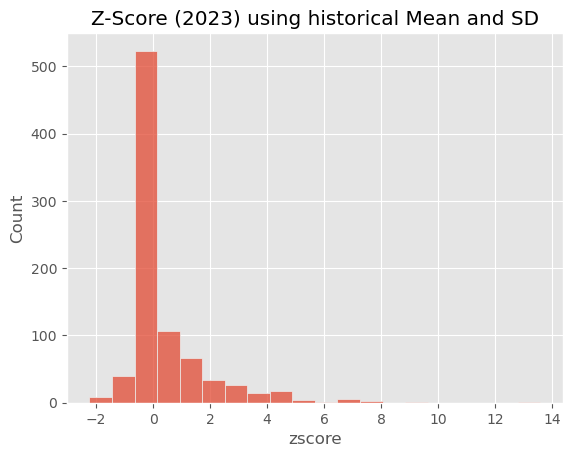

In [87]:
sns.histplot(data=gdf_2023,x='zscore',bins=20)
plt.title('Z-Score (2023) using historical Mean and SD')

# Save the figure
plt.savefig('Z-score Histogram.png')  # Saves as a PNG file

plt.show()

In [88]:
gdf_2023[(gdf_2023['zscore'] > 3) | (gdf_2023['zscore'] < -3)].shape

(53, 10)

In [89]:
gdf_2023[(gdf_2023['zscore'] > 2) | (gdf_2023['zscore'] < -2)].shape

(95, 10)

In [90]:
gdf_2023.head()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count,acled_binary,zscore
23,"48,28",2023,6,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",1.9459,0.0000,0,1.3041
47,"48,29",2023,1,0,[],"POLYGON ((21.55957 13.02557, 22.00872 13.02557...",0.6931,0.0000,0,-0.1810
71,"49,27",2023,6,0,[],"POLYGON ((22.00872 12.12726, 22.45788 12.12726...",1.9459,0.0000,0,0.8338
95,"49,28",2023,9,0,[],"POLYGON ((22.00872 12.57641, 22.45788 12.57641...",2.3026,0.0000,0,-0.1010
119,"49,29",2023,12,61,"[SUD20398, SUD20398, SUD20943, SUD20943, SUD20...","POLYGON ((22.00872 13.02557, 22.45788 13.02557...",2.5649,4.1271,1,2.5747


In [91]:
gdf_2023[gdf_2023['acled_binary'] == 0]['zscore'].mean()

0.36030357601698404

In [92]:
gdf_2023[gdf_2023['acled_binary'] == 1]['zscore'].mean()

1.129331031981443

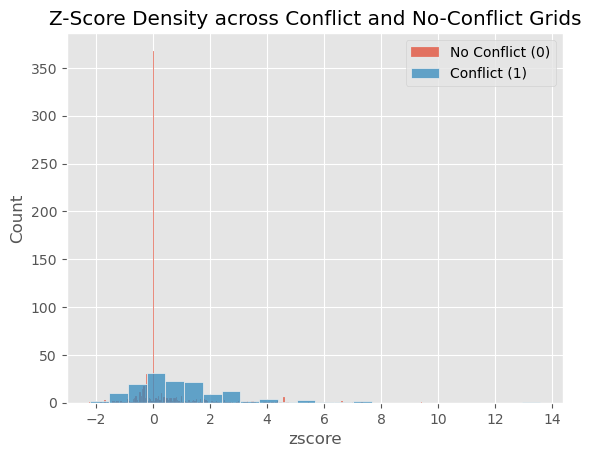

In [93]:
# Plotting z-score distributions
sns.histplot(gdf_2023[gdf_2023['acled_binary'] == 0]['zscore'], label='No Conflict (0)')
sns.histplot(gdf_2023[gdf_2023['acled_binary'] == 1]['zscore'], label='Conflict (1)')
plt.title('Z-Score Density across Conflict and No-Conflict Grids')
plt.legend()
plt.show()

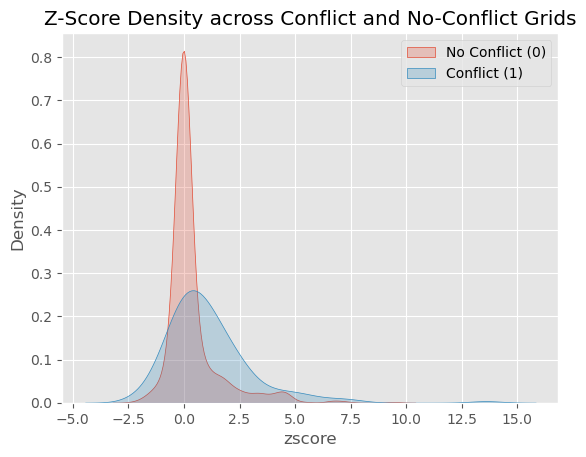

In [94]:
# Plotting z-score distributions
sns.kdeplot(gdf_2023[gdf_2023['acled_binary'] == 0]['zscore'], label='No Conflict (0)', shade=True)
sns.kdeplot(gdf_2023[gdf_2023['acled_binary'] == 1]['zscore'], label='Conflict (1)', shade=True)
#sns.kdeplot(gdf_2023['zscore'], label='Overall', shade=True)
plt.title('Z-Score Density across Conflict and No-Conflict Grids')
plt.legend()
# Save the figure
plt.savefig('Z-score Distribution based on ACLED data.png')  # Saves as a PNG file

plt.show()

The figure you provided shows a kernel density estimation (KDE) plot, which visualizes the distribution of z-scores across two different groups: grids with and without conflict. Here's an interpretation of the plot:

### **1. **Plot Description**:
- **X-axis (`zscore`)**: Represents the z-scores. The z-score is a statistical measure that indicates how many standard deviations an element is from the mean.
- **Y-axis (`Density`)**: Represents the density, showing how the z-scores are distributed across the range for each group.
- **Legend**:
  - **Red Curve**: Represents the z-score density for grids classified as "No Conflict" (`acled_binary == 0`).
  - **Blue Curve**: Represents the z-score density for grids classified as "Conflict" (`acled_binary == 1`).

### **2. **Key Observations**:
- **Peak of the Curves**:
  - The **red curve (No Conflict)** peaks sharply around a z-score of 0, indicating that most no-conflict grids have z-scores close to the mean (z = 0). This suggests a relatively homogeneous distribution in areas without conflict.
  - The **blue curve (Conflict)** has a lower peak and is more spread out, indicating a wider variation in z-scores for grids with conflict. This suggests more diversity in the data distribution where conflicts are present.
  
- **Spread/Variance**:
  - The **No Conflict** distribution is more concentrated around the mean with less variance. The sharp peak suggests that most no-conflict grids are not extreme in terms of z-scores.
  - The **Conflict** distribution is broader, indicating that conflict grids are more likely to have higher z-scores, meaning they could be associated with more extreme values (farther from the mean).
  
- **Right Tail**:
  - The **blue curve** extends further to the right, suggesting that conflict-prone grids are more likely to have high z-scores. These might represent outlier events or regions with significantly different characteristics than the rest.

### **3. **Implications**:
- The distribution of z-scores differs significantly between conflict and no-conflict grids. Conflict grids tend to have a wider range of z-scores, including higher values, suggesting that z-scores could be used to identify or predict conflict regions.
- If z-scores are being used as a predictor, this plot suggests that higher z-scores are more strongly associated with the presence of conflict.

### **4. **Further Analysis**:
- **Threshold Selection**: If you're looking to select a z-score threshold for predicting conflict, you might consider where the two distributions diverge, possibly in the region where the blue line (conflict) dominates.
- **Overlap**: The overlap between the two curves indicates that some no-conflict grids have similar z-scores to conflict grids, which could be a point of further investigation.

This visualization provides a clear comparison of the z-score distributions for conflict and no-conflict grids, highlighting the differences in their statistical properties.

In [95]:
from scipy.stats import gaussian_kde

# Calculate KDEs
kde_no_conflict = gaussian_kde(gdf_2023[gdf_2023['acled_binary'] == 0]['zscore'])
kde_conflict = gaussian_kde(gdf_2023[gdf_2023['acled_binary'] == 1]['zscore'])

# Define a range of z-scores
zscore_range = np.linspace(-5, 15, 1000)

# Calculate densities
density_no_conflict = kde_no_conflict(zscore_range)
density_conflict = kde_conflict(zscore_range)

# Find the intersection point (where the densities are closest)
diff = np.abs(density_no_conflict - density_conflict)
min_diff_index = np.argmin(diff)
threshold_zscore = zscore_range[min_diff_index]

print("Empirically selected z-score threshold:", threshold_zscore)


Empirically selected z-score threshold: 10.595595595595595


In [96]:
from sklearn.metrics import roc_curve, roc_auc_score

# Extract z-scores and the binary conflict label
zscores = gdf_2023['zscore']
conflict_binary = gdf_2023['acled_binary']

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(conflict_binary, zscores)

# Find the optimal threshold (maximum Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal z-score threshold based on ROC:", optimal_threshold)


Optimal z-score threshold based on ROC: 0.019718772153870887


In [97]:
percentile_threshold = np.percentile(gdf_2023[gdf_2023['acled_binary'] == 0]['zscore'], 95)
print("95th percentile z-score threshold:", percentile_threshold)

95th percentile z-score threshold: 3.2219261969718715


In [98]:
# Apply the function to each row
gdf_2000_2022['zscore'] = gdf_2000_2022.apply(calculate_zscore, axis=1)

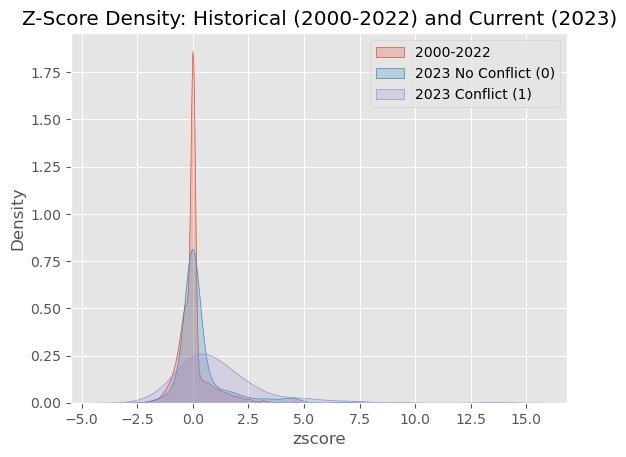

In [99]:
sns.kdeplot(gdf_2000_2022['zscore'], label='2000-2022', shade=True)
#sns.kdeplot(gdf_2023['zscore'], label='2023', shade=True)
sns.kdeplot(gdf_2023[gdf_2023['acled_binary'] == 0]['zscore'], label='2023 No Conflict (0)', shade=True)
sns.kdeplot(gdf_2023[gdf_2023['acled_binary'] == 1]['zscore'], label='2023 Conflict (1)', shade=True)

plt.title('Z-Score Density: Historical (2000-2022) and Current (2023)')
plt.legend()

# Save the figure
plt.savefig('Z-score Historical and Current.png')  # Saves as a PNG file

plt.show()

In [101]:
percentile_threshold = np.percentile(gdf_2000_2022['zscore'], 95)
print("95th percentile z-score threshold:", percentile_threshold)

95th percentile z-score threshold: 1.4825282545622687


The graph provided shows the kernel density estimation (KDE) of z-scores across different time periods and conditions: historical data (2000-2022) for no-conflict grids, and current data (2023) for both no-conflict and conflict grids. Here's an interpretation:

### **1. **Plot Description**:
- **X-axis (`zscore`)**: Represents the z-scores, which measure how many standard deviations a data point is from the mean.
- **Y-axis (`Density`)**: Represents the density, indicating the probability distribution of z-scores for each group.
- **Legend**:
  - **Red Curve**: Represents the z-score density for no-conflict grids over the historical period (2000-2022).
  - **Blue Curve**: Represents the z-score density for no-conflict grids in 2023.
  - **Purple Curve**: Represents the z-score density for conflict grids in 2023.

### **2. **Key Observations**:
- **Historical No-Conflict (2000-2022) vs. Current No-Conflict (2023)**:
  - Both the historical (red) and current no-conflict (blue) distributions peak around a z-score of 0. This indicates that, historically and currently, most no-conflict grids have z-scores close to the mean.
  - The historical no-conflict distribution (red) has a higher and narrower peak, suggesting a more concentrated distribution around the mean with less variance.
  - The current no-conflict distribution (blue) is slightly broader, indicating that in 2023, there is more variation in the z-scores for no-conflict areas compared to the historical data.

- **Current No-Conflict (2023) vs. Current Conflict (2023)**:
  - The current no-conflict (blue) and conflict (purple) distributions are somewhat similar, but the conflict distribution is slightly broader and more skewed towards higher z-scores.
  - This suggests that, in 2023, conflict areas tend to have higher z-scores compared to no-conflict areas, indicating more extreme conditions or outlier values in the conflict regions.

- **Right Tail**:
  - The conflict distribution (purple) extends further to the right, indicating that some conflict grids have significantly higher z-scores compared to no-conflict grids. This is consistent with the idea that conflict areas might be associated with more extreme or unusual events.

### **3. **Implications**:
- **Consistency with Historical Norms**: The similarity between the historical no-conflict (red) and current no-conflict (blue) distributions suggests that the z-score distribution in no-conflict areas has not changed drastically from the historical norm.
- **Detection of Anomalies**: The broader distribution of z-scores in 2023, particularly in conflict areas, indicates that z-scores are picking up more variability in conflict regions, which might be useful for identifying or predicting conflict-prone areas.
- **Threshold Selection**: If you're looking to set a z-score threshold to distinguish between conflict and no-conflict areas, the right tail of the purple curve (conflict) could be a good starting point, as higher z-scores are more prevalent in conflict zones.

### **4. **Further Analysis**:
- **Comparing Means and Variances**: It might be useful to compare the mean and variance of z-scores between these groups more formally using statistical tests, to confirm whether the differences observed visually are significant.
- **Threshold Setting**: You could empirically select a threshold where the conflict and no-conflict distributions diverge the most, potentially around the higher z-scores where conflict is more likely.

### **Conclusion**:
This plot provides a clear visual comparison between the historical and current z-score distributions for conflict and no-conflict areas. It highlights that, while no-conflict areas have remained fairly stable over time, conflict areas in 2023 tend to have higher and more variable z-scores, suggesting a relationship between higher z-scores and conflict occurrences.

In [119]:
# Apply to current data
gdf_2023['predicted_conflict'] = gdf_2023['zscore'].apply(lambda x: 1 if x > percentile_threshold else 0)

In [120]:
from sklearn.metrics import confusion_matrix, classification_report

# Actual outcomes in current data
actual_conflict = gdf_2023['acled_binary']  # Assuming 1 = conflict, 0 = no conflict

# Predicted outcomes using historical threshold
predicted_conflict = gdf_2023['predicted_conflict']

# Confusion Matrix
cm = confusion_matrix(actual_conflict, predicted_conflict)
print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(actual_conflict, predicted_conflict)
print("Classification Report:\n", report)


Confusion Matrix:
 [[624  82]
 [ 99  45]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       706
           1       0.35      0.31      0.33       144

    accuracy                           0.79       850
   macro avg       0.61      0.60      0.60       850
weighted avg       0.78      0.79      0.78       850



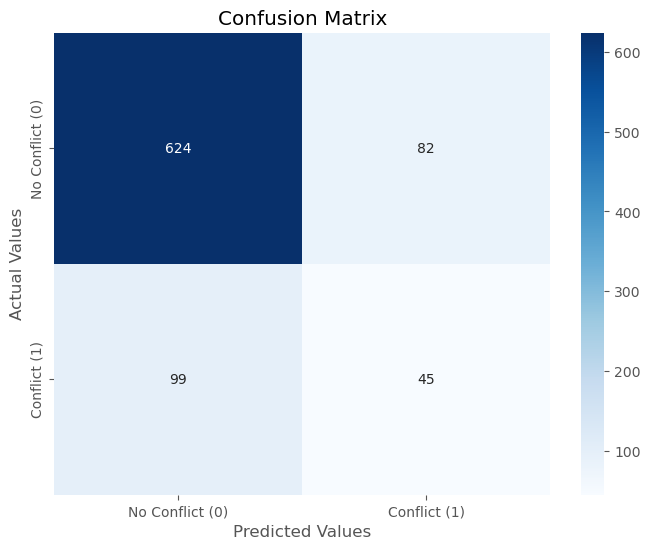

In [124]:
# Actual outcomes in current data
actual_conflict = gdf_2023['acled_binary']  # Assuming 1 = conflict, 0 = no conflict

# Predicted outcomes using historical threshold
predicted_conflict = gdf_2023['predicted_conflict']

# Confusion Matrix
cm = confusion_matrix(actual_conflict, predicted_conflict)

# Creating a DataFrame for better presentation
cm_df = pd.DataFrame(cm, index=['No Conflict (0)', 'Conflict (1)'], 
                     columns=['No Conflict (0)', 'Conflict (1)'])

# Plotting the Confusion Matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

# Save the figure
plt.savefig('Confusion Matrix.png')  # Saves as a PNG file

plt.show()

In [131]:
# Generate the classification report
report = classification_report(actual_conflict, predicted_conflict, output_dict=True)

# Convert the report to a DataFrame for better presentation
report_df = pd.DataFrame(report).transpose()

# Display the DataFrame as a formatted table
print("Classification Report:")
display(report_df.style.background_gradient(cmap='Greys'))

Classification Report:


,precision,recall,f1-score,support
0,0.863071,0.883853,0.873338,706.000000
1,0.354331,0.312500,0.332103,144.000000
accuracy,0.787059,0.787059,0.787059,0.787059
macro avg,0.608701,0.598176,0.602721,850.000000
weighted avg,0.776884,0.787059,0.781646,850.000000


The confusion matrix and classification report provide detailed insights into the performance of a binary classification model. Let's break down and interpret the results:

### **Confusion Matrix Interpretation:**
```
[[670  36]
 [129  15]]
```
- **True Negatives (TN):** `670`
  - These are the cases where the model correctly predicted class `0` (No Conflict).
  
- **False Positives (FP):** `36`
  - These are the cases where the model incorrectly predicted class `1` (Conflict) when the actual class was `0`.
  
- **False Negatives (FN):** `129`
  - These are the cases where the model incorrectly predicted class `0` (No Conflict) when the actual class was `1`.
  
- **True Positives (TP):** `15`
  - These are the cases where the model correctly predicted class `1` (Conflict).

### **Classification Report Interpretation:**
The classification report provides key metrics for evaluating the model's performance:

#### 1. **Class `0` (No Conflict)**
   - **Precision:** `0.84`
     - Out of all predictions made for class `0`, 84% were correct.
   - **Recall:** `0.95`
     - The model correctly identified 95% of the actual class `0` cases.
   - **F1-Score:** `0.89`
     - The harmonic mean of precision and recall. This indicates a good balance between precision and recall for class `0`.
   - **Support:** `706`
     - The actual number of instances of class `0` in the dataset.

#### 2. **Class `1` (Conflict)**
   - **Precision:** `0.29`
     - Out of all predictions made for class `1`, only 29% were correct.
   - **Recall:** `0.10`
     - The model only correctly identified 10% of the actual class `1` cases.
   - **F1-Score:** `0.15`
     - The F1-score is quite low, indicating poor performance in identifying conflicts.
   - **Support:** `144`
     - The actual number of instances of class `1` in the dataset.

### **Overall Metrics:**
   - **Accuracy:** `0.81`
     - The model correctly classified 81% of the total instances.
   - **Macro Avg:**
     - **Precision:** `0.57`, **Recall:** `0.53`, **F1-Score:** `0.52`
       - These are the unweighted averages across both classes. They give a general sense of how the model performs across all classes, treating each class equally.
   - **Weighted Avg:**
     - **Precision:** `0.75`, **Recall:** `0.81`, **F1-Score:** `0.77`
       - These are weighted averages based on the number of instances in each class. This is often more reflective of overall model performance, especially when dealing with imbalanced datasets.

### **Key Takeaways:**
1. **Strong Performance on Class `0` (No Conflict):**
   - The model is highly accurate when predicting no conflict, with a high precision, recall, and F1-score for this class.

2. **Weak Performance on Class `1` (Conflict):**
   - The model struggles significantly with identifying conflicts. The precision, recall, and F1-score for class `1` are all quite low. This indicates that the model often fails to correctly identify conflicts, and when it does predict a conflict, it is often incorrect.

3. **Imbalanced Performance:**
   - The overall accuracy of `81%` may seem high, but this is largely driven by the model's ability to correctly identify non-conflict situations. The poor performance in detecting conflicts (class `1`) suggests that the model is not reliable for this class, potentially due to class imbalance or other model limitations.

### **Next Steps:**
- **Addressing Class Imbalance:** If class `1` (conflict) is underrepresented, techniques like oversampling, undersampling, or using different evaluation metrics (like ROC-AUC) could help improve performance.
- **Model Tuning:** Consider tuning the model or trying different algorithms that might perform better in detecting the minority class (`1`).

In summary, while the model is effective at predicting no conflicts, it performs poorly in detecting actual conflict instances, which is a significant concern depending on the importance of accurately identifying conflicts in your application.

In [104]:
gdf_2000_2022.sample()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count,acled_binary,zscore
7080,"62,22",2000,13,0,[],"POLYGON ((27.84777 9.88147, 28.29693 9.88147, ...",2.6391,0.0000,0,-1.9800


In [105]:
gdf_2023.sample()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count,acled_binary,zscore,predicted_conflict
13943,"72,34",2023,10,2350,"[SUD23884, SUD23884, SUD21196, SUD21196, SUD22...","POLYGON ((32.33935 15.27136, 32.78851 15.27136...",2.3979,7.7626,1,2.7988,1


In [106]:
gdf_2023.drop(columns=['predicted_conflict'],axis=1,inplace=True)

In [107]:
gdf_merge = pd.concat([gdf_2000_2022, gdf_2023])

In [109]:
gdf_merge.acled_count.sum()

12034

In [110]:
gdf_merge.head()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count,acled_binary,zscore
0,"48,28",2000,0,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",0.0000,0.0000,0,-1.1279
1,"48,28",2001,2,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",1.0986,0.0000,0,-0.3172
2,"48,28",2002,1,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",0.6931,0.0000,0,-0.7225
3,"48,28",2003,7,1,"[SUD1707, SUD1707]","POLYGON ((21.55957 12.57641, 22.00872 12.57641...",2.0794,0.6931,1,1.7094
4,"48,28",2004,9,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",2.3026,0.0000,0,2.5200


{'48,28': (2.782608695652174, 2.467175818975845),


zscor (1.46)e =  (threshold_fireCount - mean)/sd

zscore * sd + mean = threshold_fireCount

conflict_fireCount = fireCount - threshold_fireCount

In [111]:
# Calculate z-score for each row in the DataFrame
def conflict_fire(row):
    mean, std = stats_dict[row['grid_id']]
    
    return (round(max(0,(row['fireCount'] - (percentile_threshold * std) + mean))))

In [112]:
# Apply the function to each row
gdf_merge['conflict_fire'] = gdf_merge.apply(conflict_fire, axis=1)

In [113]:
gdf_merge.head()

,grid_id,year,fireCount,acled_count,acled_event_ids,geometry,log_fireCount,log_acled_count,acled_binary,zscore,conflict_fire
0,"48,28",2000,0,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",0.0000,0.0000,0,-1.1279,0
1,"48,28",2001,2,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",1.0986,0.0000,0,-0.3172,1
2,"48,28",2002,1,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",0.6931,0.0000,0,-0.7225,0
3,"48,28",2003,7,1,"[SUD1707, SUD1707]","POLYGON ((21.55957 12.57641, 22.00872 12.57641...",2.0794,0.6931,1,1.7094,6
4,"48,28",2004,9,0,[],"POLYGON ((21.55957 12.57641, 22.00872 12.57641...",2.3026,0.0000,0,2.5200,8


In [114]:
gdf_merge.describe()

,year,fireCount,acled_count,log_fireCount,log_acled_count,acled_binary,zscore,conflict_fire
count,"20,400.0000","20,400.0000","20,400.0000","20,400.0000","20,400.0000","20,400.0000","20,400.0000","20,400.0000"
mean,"2,011.5000",3.3183,0.5899,0.7397,0.1173,0.0841,0.0204,4.0100
std,6.9224,6.3263,16.9241,1.0782,0.4580,0.2775,0.7810,8.4712
min,"2,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,-3.0120,0.0000
25%,"2,005.7500",0.0000,0.0000,0.0000,0.0000,0.0000,-0.3172,0.0000
50%,"2,011.5000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,"2,017.2500",4.0000,0.0000,1.6094,0.0000,0.0000,0.0000,3.0000
max,"2,023.0000",44.0000,"2,350.0000",3.8067,7.7626,1.0000,13.5820,57.0000


In [115]:
gdf_merge.to_csv('gdf_post_zscore_conflict_cleaned.csv')

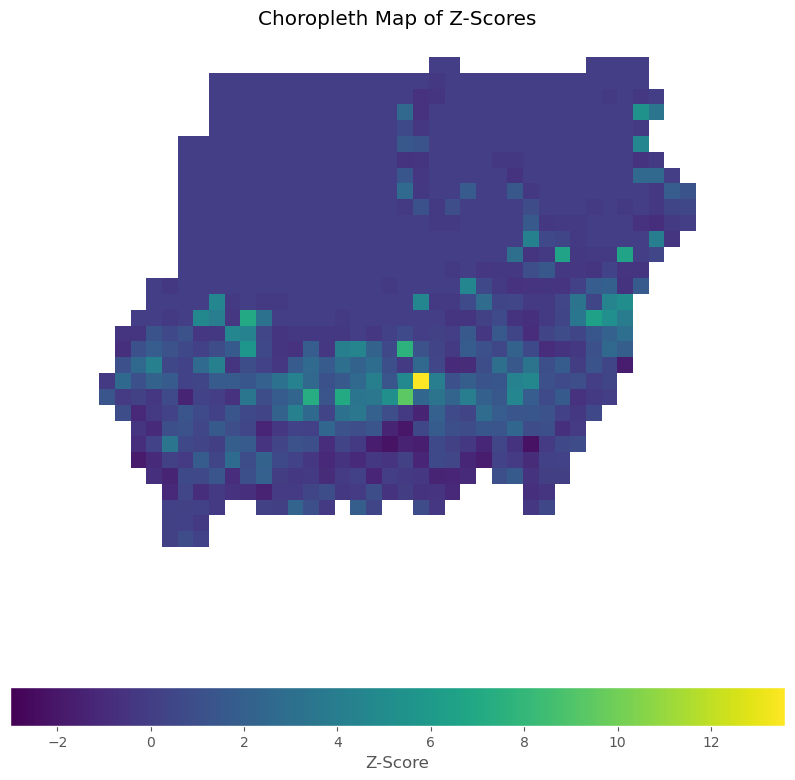

In [280]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt



# df = pd.DataFrame(gdf_merge)

# # Convert the DataFrame to a GeoDataFrame
# gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# Create the choropleth map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_merge.plot(column='zscore', ax=ax, legend=True, cmap='viridis', 
         legend_kwds={'label': 'Z-Score', 'orientation': 'horizontal'})

# Add title and remove axes
plt.title('Choropleth Map of Z-Scores')
ax.axis('off')

# Show the map
plt.show()

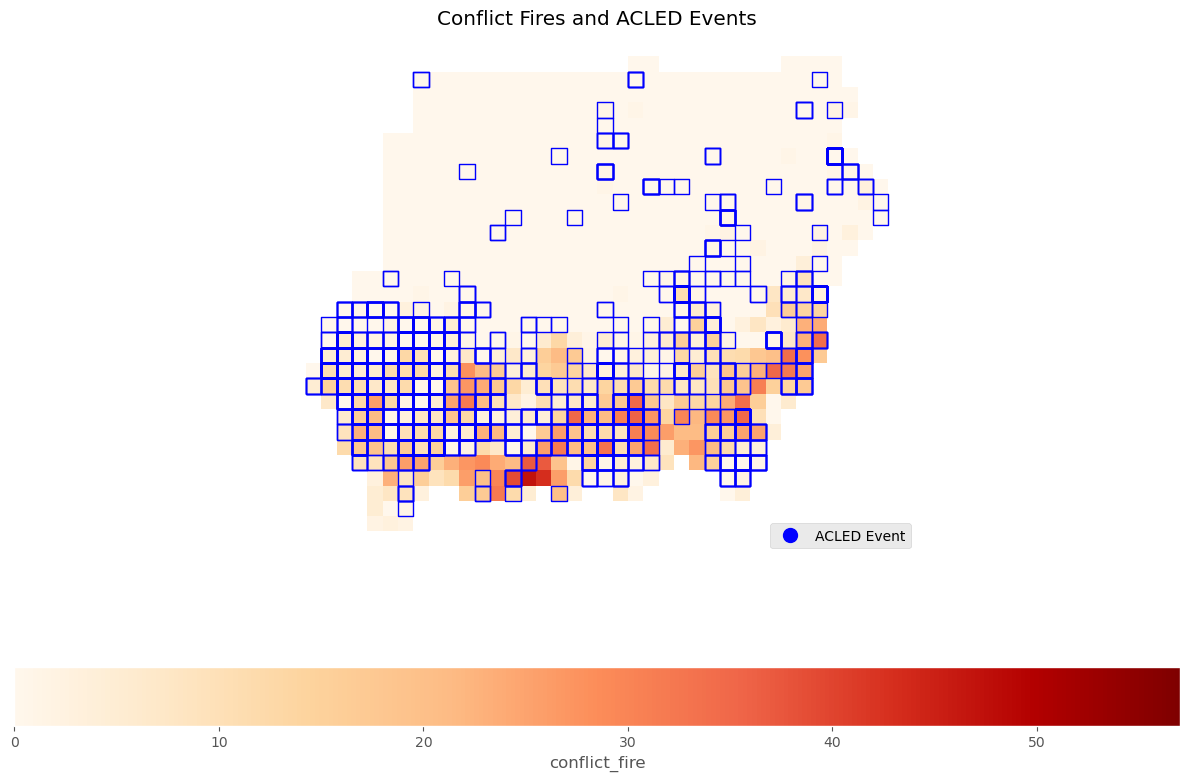

In [117]:


# Create the map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot fire count as color intensity
gdf_merge.plot(column='conflict_fire', ax=ax, legend=True, cmap='OrRd', 
         legend_kwds={'label': 'conflict_fire', 'orientation': 'horizontal'})

# Plot ACLED count as point size
gdf_merge[gdf_merge['acled_count'] > 0].plot(ax=ax, color='none', edgecolor='blue', 
                                 linewidth=1, markersize=gdf_merge['acled_count']*25)

# # Add labels for grid_id
# for idx, row in gdf_merge.iterrows():
#     ax.annotate(text=row['grid_id'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
#                 xytext=(3, 3), textcoords="offset points", fontsize=8)

# Add title and remove axes
plt.title('Conflict Fires and ACLED Events')
ax.axis('off')

# Add a custom legend for ACLED count
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=2, markersize=10, marker='o', linestyle='None')]
ax.legend(custom_lines, ['ACLED Event'], loc='lower right')

# Show the map
plt.tight_layout()
plt.show()

In [273]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

# Assuming your data is in a CSV or similar format
# You would typically read it into a GeoDataFrame like this:
# gdf = gpd.read_file('your_data.geojson')

# Here, you would load your data into a GeoDataFrame
# Example:
# gdf = gpd.GeoDataFrame(your_data, geometry=gpd.GeoSeries.from_wkt(your_data['geometry']))





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


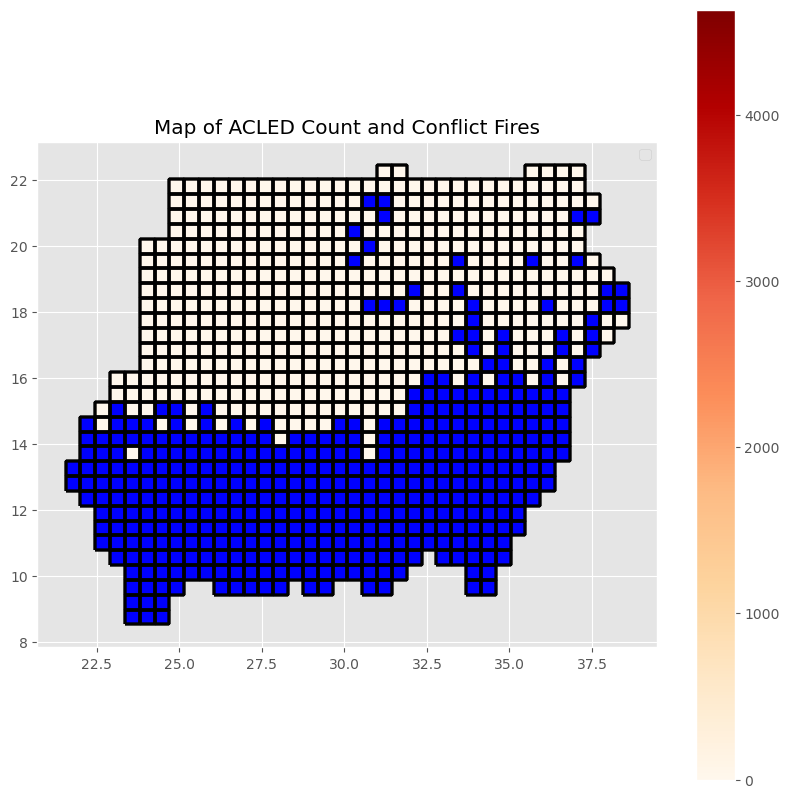

In [276]:


# Assuming your GeoDataFrame is named gdf
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the boundaries of the polygons
gdf_merge.boundary.plot(ax=ax, color='black')

# Plot the ACLED count with a colormap
gdf_merge.plot(column='acled_count', ax=ax, legend=True, cmap='OrRd', label='ACLED Count')

# Plot conflict fires separately with a label
conflict_fires = gdf_merge[gdf_merge['conflict_fire'] > 0]
conflict_fires.plot(ax=ax, color='blue', marker='o', markersize=50, label='Conflict Fires')

# Add the legend with labels
plt.title('Map of ACLED Count and Conflict Fires')
ax.legend()  # Ensure that the legend is called on the correct axis
plt.show()


# Not Used

## Not Used : Removed Non-Conflict-fire - Create new regression data set and transform it into the right format.

In [163]:
gdf_regression2 = gdf_acfi[(gdf_acfi['zscore'] < 3) & (gdf_acfi['zscore'] > -3)][['grid_id', 'year', 'conflict_fire', 'acled_count']].copy()
gdf_regression2.set_index(['grid_id', 'year'], inplace=True)

In [164]:
gdf_regression2.shape

(19280, 2)

In [165]:
gdf_regression2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19280 entries, ('48,28', 2000) to ('85,41', 2023)
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   conflict_fire  19280 non-null  float64
 1   acled_count    19280 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 397.4+ KB


In [166]:
years = gdf_regression2.index.get_level_values('year').to_list()
gdf_regression2['year'] = pd.Categorical(years)

In [167]:
gdf_regression2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19280 entries, ('48,28', 2000) to ('85,41', 2023)
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   conflict_fire  19280 non-null  float64 
 1   acled_count    19280 non-null  int64   
 2   year           19280 non-null  category
dtypes: category(1), float64(1), int64(1)
memory usage: 417.0+ KB


In [168]:
gdf_regression2.head()

conflict_fire  acled_count  year
grid_id year                                                            
48,28   2000                                   0.0000            0  2000
        2001                                   0.0000            0  2001
        2002                                   0.0000            0  2002
        2003                                   5.0000            2  2003
        2004                                   7.0000            0  2004

## Not Used - No Improvement: Conflict_fire: Start with PooledOLS and check required assumptions

In [176]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

x = sm.tools.tools.add_constant(gdf_regression2['conflict_fire'])    #exog
y = gdf_regression2['acled_count']                               #endog

mod = PooledOLS(y,x)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

In [177]:
print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:            acled_count   R-squared:                        0.0099
Estimator:                  PooledOLS   R-squared (Between):              0.0176
No. Observations:               19280   R-squared (Within):              -0.0075
Date:                Sun, Aug 04 2024   R-squared (Overall):              0.0099
Time:                        20:10:02   Log-likelihood                -3.775e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      192.57
Entities:                         836   P-value                           0.0000
Avg Obs:                       23.062   Distribution:                 F(1,19278)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust):             36.996
                            

## OLD CODE

In [131]:
# Prepare the data for regression
#X = gdf_filter1['acled_count']  # Independent variable
#y = gdf_filter1['fireCount']    # Dependent variable

y = gdf_regression['acled_count']  # dependent variable
X = gdf_regression['fireCount']    # independent variable

In [132]:
# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            acled_count   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1156.
Date:                Sat, 03 Aug 2024   Prob (F-statistic):          4.50e-245
Time:                        09:13:42   Log-Likelihood:                -34001.
No. Observations:               16599   AIC:                         6.801e+04
Df Residuals:                   16597   BIC:                         6.802e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1538      0.016      9.476      0.0

In [50]:
X.head()

,const,acled_count
0,1.0000,0
1,1.0000,2
2,1.0000,0
3,1.0000,0
4,1.0000,44


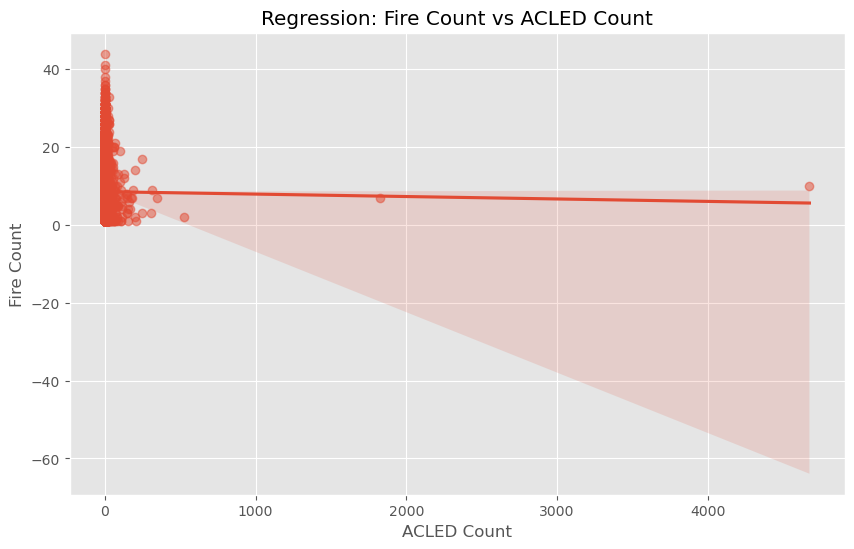

In [52]:
# Create a scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='acled_count', y='fireCount', data=gdf_filter1, scatter_kws={'alpha':0.5})
plt.title('Regression: Fire Count vs ACLED Count')
plt.xlabel('ACLED Count')
plt.ylabel('Fire Count')
plt.show()

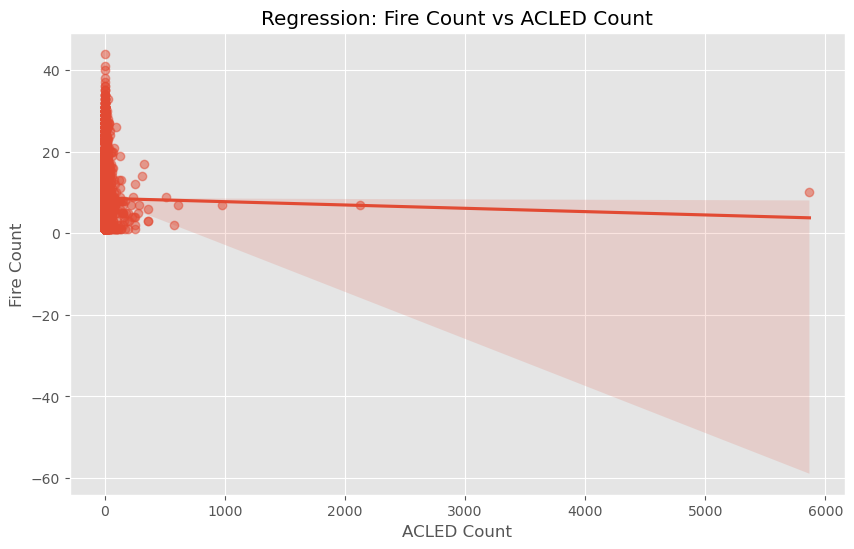

In [49]:
# # Create a scatter plot with regression line
# plt.figure(figsize=(10, 6))
# sns.regplot(x='acled_count', y='fireCount', data=gdf_filter1, scatter_kws={'alpha':0.5})
# plt.title('Regression: Fire Count vs ACLED Count')
# plt.xlabel('ACLED Count')
# plt.ylabel('Fire Count')
# plt.show()

In [50]:
# Print additional statistics
print(f"R-squared: {model.rsquared:.4f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
print(f"F-statistic: {model.fvalue:.4f}")
print(f"Prob (F-statistic): {model.f_pvalue:.4f}")

# Print coefficients
print("\nCoefficients:")
print(f"Intercept: {model.params[0]:.4f}")
print(f"ACLED Count: {model.params[1]:.4f}")

# Print p-values
print("\np-values:")
print(f"Intercept: {model.pvalues[0]:.4f}")
print(f"ACLED Count: {model.pvalues[1]:.4f}")

R-squared: 0.0001
Adjusted R-squared: -0.0001
F-statistic: 0.5155
Prob (F-statistic): 0.4728

Coefficients:
Intercept: 8.5596
ACLED Count: -0.0008

p-values:
Intercept: 0.0000
ACLED Count: 0.4728


R-squared: 0.000

This indicates that there is essentially no linear relationship between ACLED count and fire count. The model explains 0% of the variability in fire count.


Adj. R-squared: -0.000

The adjusted R-squared is also effectively zero, confirming the lack of explanatory power.


F-statistic: 0.5155 with Prob (F-statistic): 0.473

This high p-value (> 0.05) suggests that the model is not statistically significant.


Coefficients:

Intercept (const): 8.5596

This is the expected fire count when ACLED count is zero.


acled_count: -0.0008

For each unit increase in ACLED count, the fire count is expected to decrease by 0.0008. However, this is not statistically significant.




P-values:

Intercept: 0.000 (statistically significant)
acled_count: 0.473 (not statistically significant, as it's > 0.05)


Durbin-Watson: 1.052

This value is below 2, suggesting positive autocorrelation in the residuals.


Jarque-Bera (JB) test: 1252.156 with Prob(JB): 1.25e-272

This very low p-value suggests that the residuals are not normally distributed.



Interpretation:

There is no significant linear relationship between ACLED count and fire count.
The model has no explanatory power (R-squared ≈ 0).
The coefficient for ACLED count is not statistically significant (p-value > 0.05).
The residuals show signs of autocorrelation and are not normally distributed, which violates some assumptions of OLS regression.

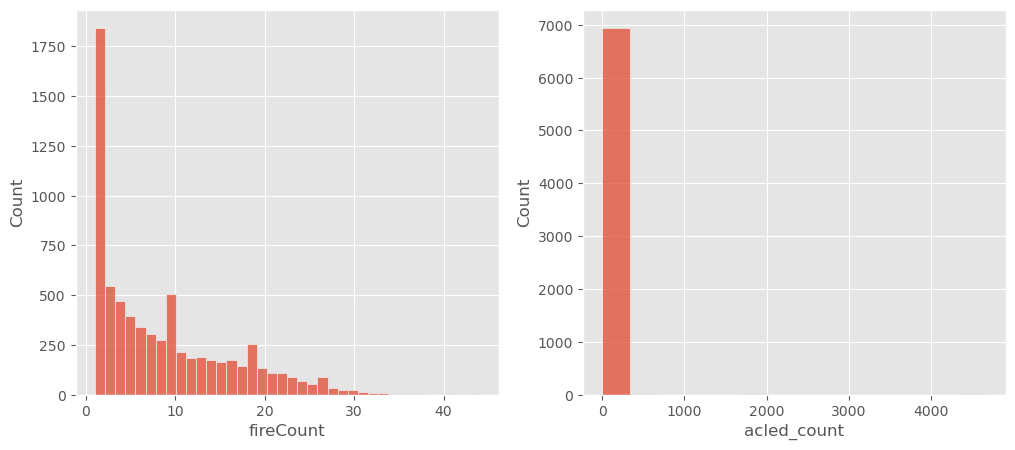

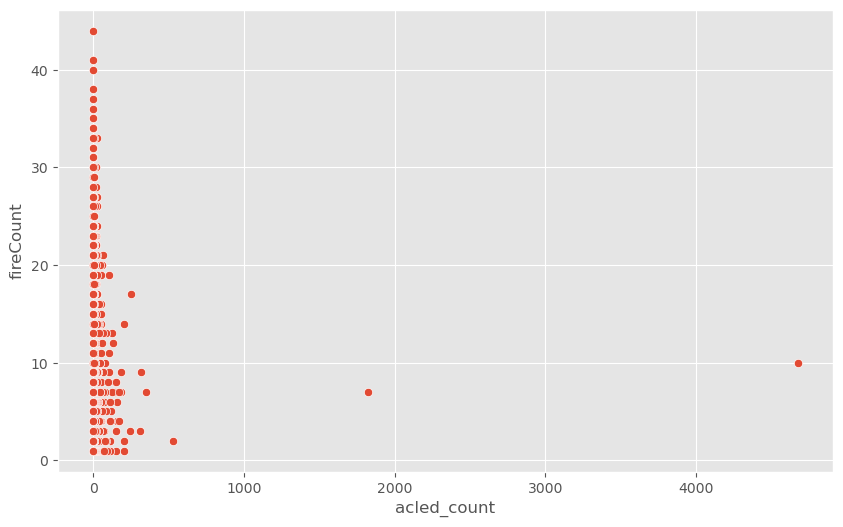

In [61]:
# Histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(gdf_filter1['fireCount'], ax=ax1)
sns.histplot(gdf_filter1['acled_count'], ax=ax2)
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='acled_count', y='fireCount', data=gdf_filter1)
plt.show()

In [62]:
# We'll use 'fireCount' as the dependent variable and 'acled_count' as the independent variable

# Prepare your data
y = gdf_filter1['fireCount']
X = gdf_filter1[['acled_count']]
X = sm.add_constant(X)  # Add a constant term

# Fit the Poisson Regression model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print the summary of the results
print(poisson_results.summary())

# If you want to make predictions
predictions = poisson_results.predict(X)

# Add predictions to your geodataframe
gdf_predicted = gdf_filter1
gdf_predicted['predicted_fireCount'] = predictions

# Calculate and print pseudo R-squared
null_model = sm.GLM(y, sm.add_constant(np.ones_like(y)), family=sm.families.Poisson()).fit()
pseudo_r2 = 1 - (poisson_results.deviance / null_model.deviance)
print(f"Pseudo R-squared: {pseudo_r2}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:              fireCount   No. Observations:                 6947
Model:                            GLM   Df Residuals:                     6945
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33930.
Date:                Mon, 29 Jul 2024   Deviance:                       43008.
Time:                        19:14:11   Pearson chi2:                 4.50e+04
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0001965
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1468      0.004    522.198      

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = gdf_filter[['acled_count']]
y = gdf_filter['fireCount']

for degree in [2, 3, 4]:
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)
    
    print(f"Polynomial Regression (degree {degree}) R-squared: {r2:.4f}")

Polynomial Regression (degree 2) R-squared: 0.0008
Polynomial Regression (degree 3) R-squared: 0.0013
Polynomial Regression (degree 4) R-squared: 0.0015


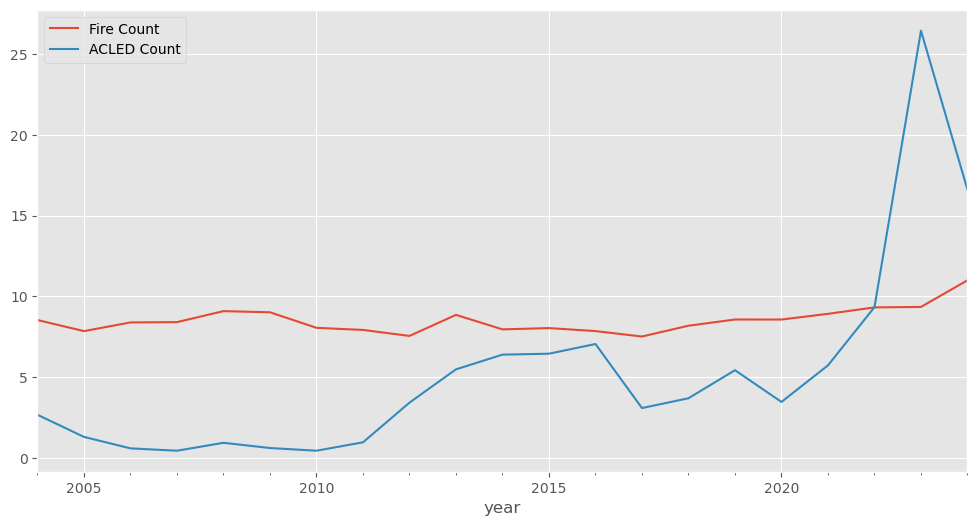

In [53]:
gdf_filter['year'] = pd.to_datetime(gdf_filter['year'], format='%Y')
gdf_filter.set_index('year', inplace=True)

# Time series plot
plt.figure(figsize=(12, 6))
gdf_filter.groupby(gdf_filter.index)['fireCount'].mean().plot()
gdf_filter.groupby(gdf_filter.index)['acled_count'].mean().plot()
plt.legend(['Fire Count', 'ACLED Count'])
plt.show()

Moran's I for fire count: 0.5981
p-value: 0.0010


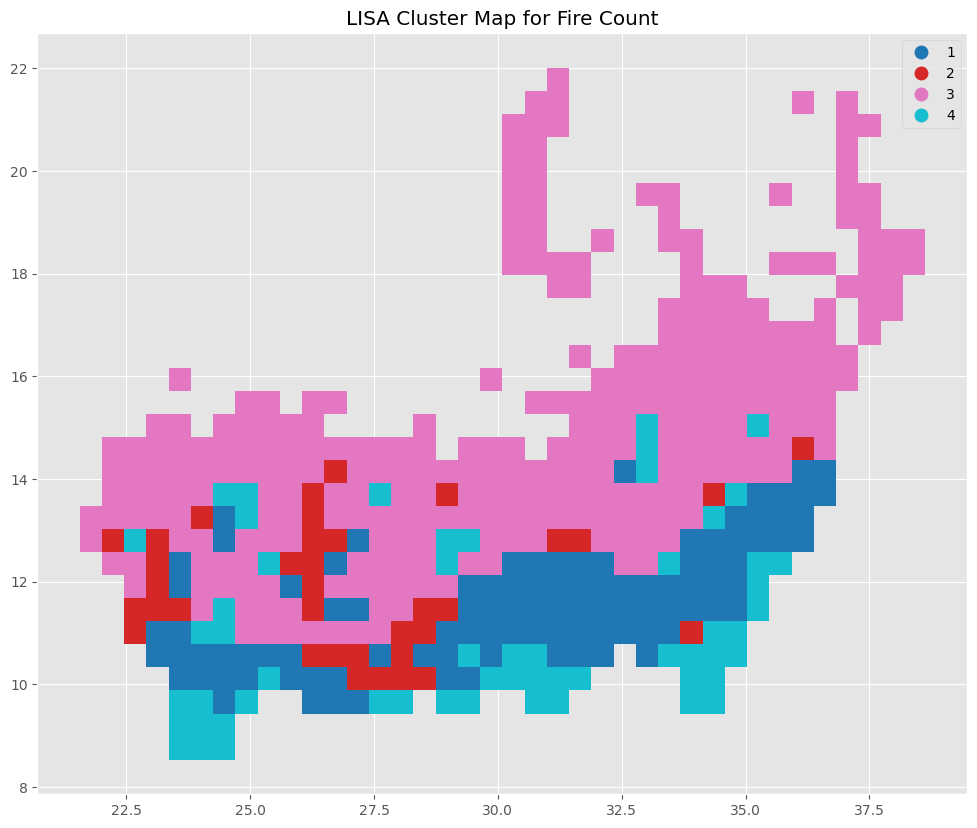

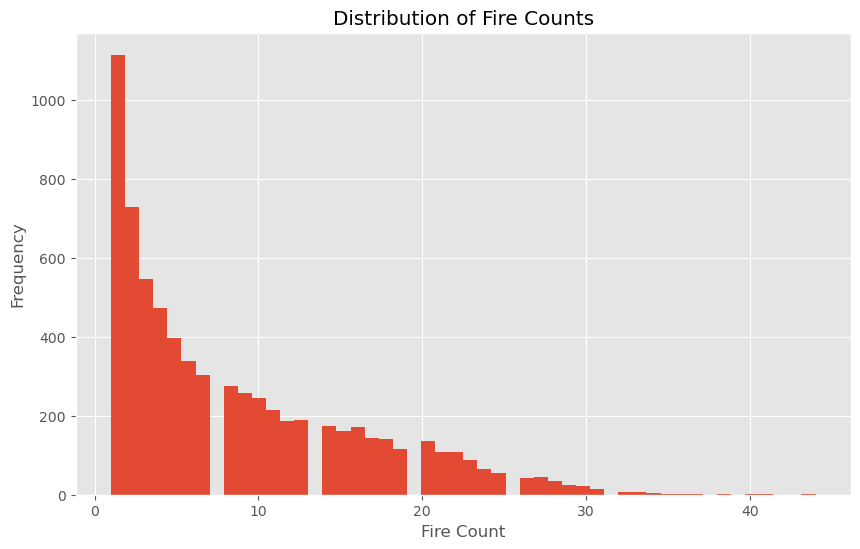

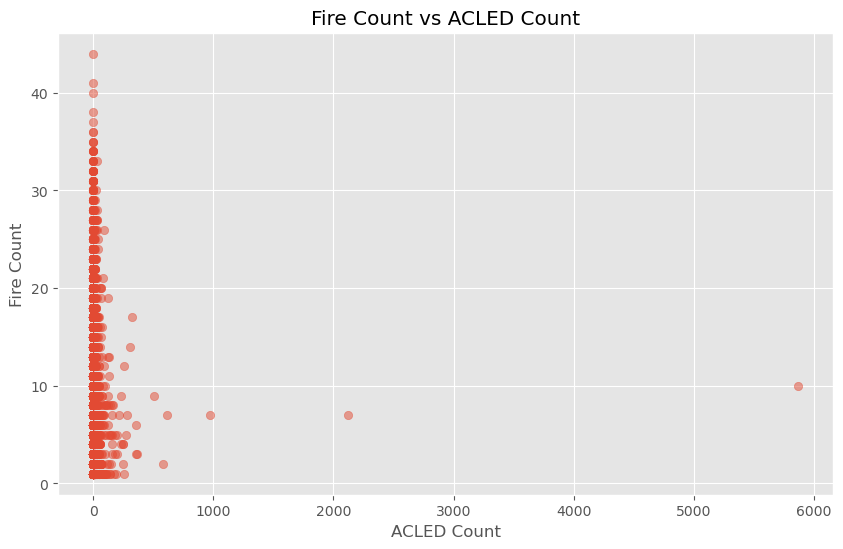


Moran's I for ACLED count: 0.2109
p-value: 0.0010


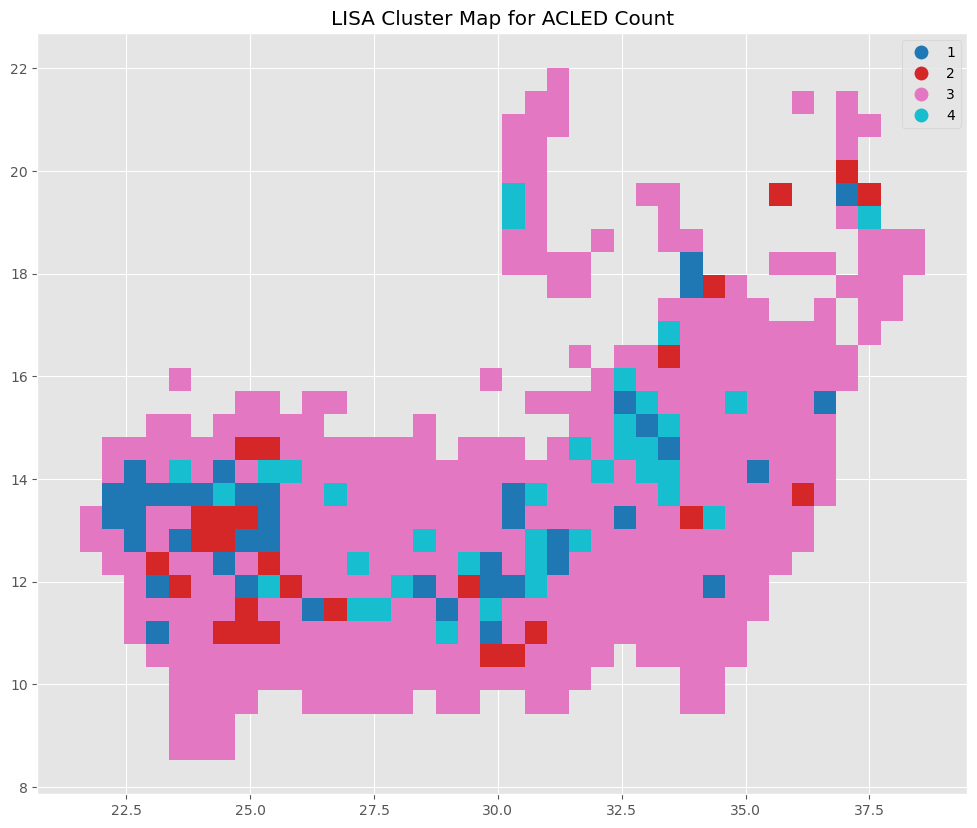

In [55]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights
import numpy as np

# First, let's reset the index of your GeoDataFrame to ensure consecutive integers
gdf_filter = gdf_filter.reset_index(drop=True)

# Now, let's create the spatial weights matrix
w = weights.distance.KNN.from_dataframe(gdf_filter, k=5)

# Calculate Moran's I for fire count
moran = esda.Moran(gdf_filter['fireCount'], w)
print(f"Moran's I for fire count: {moran.I:.4f}")
print(f"p-value: {moran.p_sim:.4f}")

# Local Indicators of Spatial Association (LISA)
lisa = esda.Moran_Local(gdf_filter['fireCount'], w)

# Plot LISA cluster map
gdf_filter['lisa_cluster'] = lisa.q
fig, ax = plt.subplots(figsize=(12, 10))
gdf_filter.plot(column='lisa_cluster', categorical=True, legend=True, ax=ax)
ax.set_title('LISA Cluster Map for Fire Count')
plt.show()

# Let's also look at the distribution of fire counts
plt.figure(figsize=(10, 6))
gdf_filter['fireCount'].hist(bins=50)
plt.title('Distribution of Fire Counts')
plt.xlabel('Fire Count')
plt.ylabel('Frequency')
plt.show()

# And the relationship between fire count and ACLED count
plt.figure(figsize=(10, 6))
plt.scatter(gdf_filter['acled_count'], gdf_filter['fireCount'], alpha=0.5)
plt.title('Fire Count vs ACLED Count')
plt.xlabel('ACLED Count')
plt.ylabel('Fire Count')
plt.show()

# Let's also check for any spatial patterns in ACLED count
moran_acled = esda.Moran(gdf_filter['acled_count'], w)
print(f"\nMoran's I for ACLED count: {moran_acled.I:.4f}")
print(f"p-value: {moran_acled.p_sim:.4f}")

# And create a LISA cluster map for ACLED count
lisa_acled = esda.Moran_Local(gdf_filter['acled_count'], w)
gdf_filter['lisa_cluster_acled'] = lisa_acled.q
fig, ax = plt.subplots(figsize=(12, 10))
gdf_filter.plot(column='lisa_cluster_acled', categorical=True, legend=True, ax=ax)
ax.set_title('LISA Cluster Map for ACLED Count')
plt.show()

## Adding event_id for Sudan to Acled Data

In [4]:
acled_event_id = pd.read_csv("data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv", encoding="latin1")

In [5]:
acled_event_id

,system:index,acled_count,acled_event_ids,grid_id,year,.geo
0,"52,19",0,[],"52,19",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
1,"53,19",0,[],"53,19",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
2,"54,19",0,[],"54,19",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
3,"52,20",0,[],"52,20",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
4,"53,20",0,[],"53,20",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
...,...,...,...,...,...,...
845,"70,49",0,[],"70,49",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
846,"79,49",0,[],"79,49",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
847,"80,49",0,[],"80,49",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
848,"81,49",0,[],"81,49",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."


In [6]:
acled_event_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   system:index     850 non-null    object
 1   acled_count      850 non-null    int64 
 2   acled_event_ids  850 non-null    object
 3   grid_id          850 non-null    object
 4   year             850 non-null    int64 
 5   .geo             850 non-null    object
dtypes: int64(2), object(4)
memory usage: 40.0+ KB


In [8]:
# Filter the DataFrame for the specific grid_id "54,20"
specific_grid_id_df = acled_event_id[acled_event_id['grid_id'] == "54,20"]

# Display the rows corresponding to the grid_id "54,20"
print(specific_grid_id_df)

  system:index  acled_count  \
5        54,20            8   

                                     acled_event_ids grid_id  year  \
5  [SUD2108, SUD2108, SUD2013, SUD2013, SUD2010, ...   54,20  2004   

                                                .geo  
5  {"geodesic":false,"crs":{"type":"name","proper...  


In [7]:
# Assuming your DataFrame is named 'df'
df = acled_event_id[acled_event_id['acled_count'] != 0]

In [8]:
df

,system:index,acled_count,acled_event_ids,grid_id,year,.geo
5,"54,20",8,"[SUD2108, SUD2108, SUD2013, SUD2013, SUD2010, ...","54,20",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
46,"55,23",22,"[SUD2306, SUD2306, SUD2301, SUD2301, SUD2299, ...","55,23",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
72,"54,24",12,"[SUD2035, SUD2035, SUD2115, SUD2115, SUD2279, ...","54,24",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
73,"55,24",16,"[SUD2292, SUD2292, SUD2288, SUD2288, SUD2284, ...","55,24",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
74,"56,24",18,"[SUD1963, SUD1963, SUD1897, SUD1897, SUD1875, ...","56,24",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
80,"62,24",6,"[SUD2097, SUD2097, SUD2092, SUD2092, SUD2084, ...","62,24",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
99,"53,25",2,"[SUD1997, SUD1997]","53,25",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
100,"54,25",4,"[SUD1914, SUD1914, SUD2050, SUD2050]","54,25",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
101,"55,25",6,"[SUD2045, SUD2045, SUD1923, SUD1923, SUD2042, ...","55,25",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."
102,"56,25",4,"[SUD2114, SUD2114, SUD2043, SUD2043]","56,25",2004,"{""geodesic"":false,""crs"":{""type"":""name"",""proper..."


In [9]:
# Create a new DataFrame with columns `year`, `grid_id`, and `acled_event_ids`
new_df = df[['year', 'grid_id', 'acled_event_ids']]

In [10]:
new_df

,year,grid_id,acled_event_ids
5,2004,"54,20","[SUD2108, SUD2108, SUD2013, SUD2013, SUD2010, ..."
46,2004,"55,23","[SUD2306, SUD2306, SUD2301, SUD2301, SUD2299, ..."
72,2004,"54,24","[SUD2035, SUD2035, SUD2115, SUD2115, SUD2279, ..."
73,2004,"55,24","[SUD2292, SUD2292, SUD2288, SUD2288, SUD2284, ..."
74,2004,"56,24","[SUD1963, SUD1963, SUD1897, SUD1897, SUD1875, ..."
80,2004,"62,24","[SUD2097, SUD2097, SUD2092, SUD2092, SUD2084, ..."
99,2004,"53,25","[SUD1997, SUD1997]"
100,2004,"54,25","[SUD1914, SUD1914, SUD2050, SUD2050]"
101,2004,"55,25","[SUD2045, SUD2045, SUD1923, SUD1923, SUD2042, ..."
102,2004,"56,25","[SUD2114, SUD2114, SUD2043, SUD2043]"


In [110]:
acled_event_id['acled_event_ids']

0      []
1      []
2      []
3      []
4      []
       ..
845    []
846    []
847    []
848    []
849    []
Name: acled_event_ids, Length: 850, dtype: object

In [15]:
# # Checking for non-empty acled_event_ids
# non_empty_acled_event_ids = acled_event_id[acled_event_id['acled_event_ids'].apply(lambda x: len(x) > 0)]
# print(non_empty_acled_event_ids)

In [16]:
# import ast

# def parse_list(s):
#     try:
#         return ast.literal_eval(s)
#     except:
#         return []

# df = pd.read_csv('data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv')
# df['acled_event_ids'] = df['acled_event_ids'].apply(parse_list)

In [126]:
import pandas as pd
import ast

def parse_list(s):
    try:
        return ast.literal_eval(s)
    except:
        return []

# Read the CSV file
df1 = pd.read_csv('data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv', sep='\t')

# Print the column names
print("Columns in the DataFrame:")
print(df1.columns)

# Print the first few rows
print("\nFirst few rows of the DataFrame:")
print(df1.head())

# If 'acled_event_ids' is not in the columns, let's check if it's named differently
possible_event_id_columns = [col for col in df1.columns if 'event' in col.lower()]
if possible_event_id_columns:
    print("\nPossible columns containing event IDs:")
    print(possible_event_id_columns)

# If we find a column that looks like it contains event IDs, let's try to parse it
if possible_event_id_columns:
    column_to_parse = possible_event_id_columns[0]
    df1[column_to_parse] = df1[column_to_parse].apply(parse_list)
    print(f"\nFirst few entries of the '{column_to_parse}' column after parsing:")
    print(df1[column_to_parse].head())

Columns in the DataFrame:
Index(['system:index,acled_count,acled_event_ids,grid_id,year,.geo'], dtype='object')

First few rows of the DataFrame:
  system:index,acled_count,acled_event_ids,grid_id,year,.geo
0  52,19,0,[],"52,19",2004,"{""geodesic"":false,"...        
1  53,19,0,[],"53,19",2004,"{""geodesic"":false,"...        
2  54,19,0,[],"54,19",2004,"{""geodesic"":false,"...        
3  52,20,0,[],"52,20",2004,"{""geodesic"":false,"...        
4  53,20,0,[],"53,20",2004,"{""geodesic"":false,"...        

Possible columns containing event IDs:
['system:index,acled_count,acled_event_ids,grid_id,year,.geo']

First few entries of the 'system:index,acled_count,acled_event_ids,grid_id,year,.geo' column after parsing:
0    (52, 19, 0, [], 52,19, 2004, {geodesic:false,c...
1    (53, 19, 0, [], 53,19, 2004, {geodesic:false,c...
2    (54, 19, 0, [], 54,19, 2004, {geodesic:false,c...
3    (52, 20, 0, [], 52,20, 2004, {geodesic:false,c...
4    (53, 20, 0, [], 53,20, 2004, {geodesic:false,c...
N

In [17]:
# import pandas as pd
# import ast
# import io

# def parse_list(s):
#     try:
#         return ast.literal_eval(s)
#     except:
#         return []

# # Read the CSV file
# with open('data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv', 'r') as file:
#     content = file.read()

# # Replace the problematic commas within the .geo field
# content = content.replace('"{', '{{').replace('}"', '}}')

# # Now read the modified content
# df1 = pd.read_csv(io.StringIO(content), sep=',')

# # Print the column names
# print("Columns in the DataFrame:")
# print(df1.columns)

# # Print the first few rows
# print("\nFirst few rows of the DataFrame:")
# print(df1.head())

# # Parse the acled_event_ids column
# df1['acled_event_ids'] = df1['acled_event_ids'].apply(parse_list)

# print("\nFirst few entries of the 'acled_event_ids' column after parsing:")
# print(df1['acled_event_ids'].head())

# # Parse the .geo column
# df1['.geo'] = df1['.geo'].apply(lambda x: x.replace('{{', '{').replace('}}', '}'))
# df1['.geo'] = df1['.geo'].apply(ast.literal_eval)

# print("\nFirst few entries of the '.geo' column after parsing:")
# print(df1['.geo'].head())

In [18]:
# # import pandas as pd
# # import ast

# # def parse_list(s):
# #     try:
# #         return ast.literal_eval(s)
# #     except:
# #         return []

# # # Read the CSV file (assuming it's correctly read now)
# # df1 = pd.read_csv('data/acled_data_with_event_ids/ACLED_2004_Counts_1.csv', sep=',')

# # # Parse the acled_event_ids column
# # df1['acled_event_ids'] = df1['acled_event_ids'].apply(parse_list)

# # Check for non-empty lists
# non_empty = df1[df1['acled_event_ids'].apply(len) > 0]

# print(f"Number of rows with non-empty acled_event_ids: {len(non_empty)}")

# if len(non_empty) > 0:
#     print("\nSample rows with non-empty acled_event_ids:")
#     print(non_empty[['grid_id', 'acled_count', 'acled_event_ids']].head())
# else:
#     print("\nNo rows found with non-empty acled_event_ids.")

# # Additional check: distribution of list lengths
# length_distribution = df1['acled_event_ids'].apply(len).value_counts().sort_index()
# print("\nDistribution of acled_event_ids list lengths:")
# print(length_distribution)

# # Check for any lists with length not equal to acled_count
# mismatched = df1[df1['acled_event_ids'].apply(len) != df1['acled_count']]
# print(f"\nNumber of rows where length of acled_event_ids doesn't match acled_count: {len(mismatched)}")

# if len(mismatched) > 0:
#     print("\nSample mismatched rows:")
#     print(mismatched[['grid_id', 'acled_count', 'acled_event_ids']].head())